**Set random seed for reproducability**

In [1]:
import os
import numpy as np 
import tensorflow as tf
randseed = 42
np.random.seed(randseed)
tf.random.set_seed(randseed)
os.environ['PYTHONHASHSEED']=str(randseed)

**Import packages**

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from keras import backend as K
from keras.models import Sequential, load_model 
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

**Read in dataset**

In [3]:
#Read in the Dataset
original = pd.read_csv('/kaggle/input/stocks/NED.csv') 
original['Date'] = pd.to_datetime(original.Date) 
original.head()

Date   Open   High    Low  Close  Volume  Earnings Yield (EY)  \
0 1999-01-01  10020  10400  10000  10020       0                  7.9   
1 1999-01-04  10020  10200   9970  10200  105704                  7.8   
2 1999-01-05  10300  10620  10300  10620  200164                  7.5   
3 1999-01-06  10800  11800  10800  11660  510807                  6.8   
4 1999-01-07  11700  12080  11700  11720  557527                  6.8   

   Dividend Yield (DY)  P:E Ratio (P:E) Trades Trade Value  \
0                  0.8        12.658228      -           -   
1                  0.8        12.820513      -           -   
2                  0.8        13.333333      -           -   
3                  0.7        14.705882      -           -   
4                  0.7        14.705882      -           -   

   Total Return Index (TRI)  
0                     387.0  
1                     394.0  
2                     410.0  
3                     450.0  
4                     452.0

**Feature Engineering**

In [4]:
forecastHorizon = 5

#Create new dataframe
df = pd.DataFrame(data = original['Date'])  

#Target Returns (Weekly)
df['Target'] = np.log(original['Close'].shift(-forecastHorizon) / original['Close'])

#Returns from the closing price
df['Returns'] = np.log((original['Close']) / original['Close'].shift(forecastHorizon))

#Lagged Variations of returns
df['Returns1'] = np.log((original['Close']) / original['Close'].shift(1))
df['Returns2'] = np.log((original['Close']) / original['Close'].shift(2))
df['Returns3'] = np.log((original['Close']) / original['Close'].shift(3))
df['Returns4'] = np.log((original['Close']) / original['Close'].shift(4))

#Simple Moving Average (SMA) and Exponentially-weighted Moving Average (EWMA) - 5, 10, 20, 50, 200 days
numDays = 5
df['SMA (5)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (5)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 10
df['SMA (10)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (10)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 20
df['SMA (20)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (20)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 50
df['SMA (50)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (50)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 200
df['SMA (200)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (200)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

#Relative Strength Index (RSI)
numDays = 14
diff = original['Close'].diff(1)
up, down = diff.copy(), diff.copy()
up[up < 0] = 0
down[down > 0] = 0
EWMAu = up.ewm(span = numDays, min_periods = numDays).mean()
EWMAd = down.abs().ewm(span = numDays, min_periods = numDays).mean()
RS = EWMAu / EWMAd
df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

#Moving Average Convergence Divergence (MACD)
df['MACD'] = df['Returns'].ewm(span = 12, min_periods = 12).mean()  - df['Returns'].ewm(span = 26, min_periods = 26).mean() 

#Commodity Channel Index (CCI) 
df['Typical Price'] = (original['High'] + original['Low'] + original['Close']) / 3
numDays = 20
df['CCI'] = (df['Typical Price'] - df['Typical Price'].rolling(numDays).mean()) / (0.015 * df['Typical Price'].rolling(numDays).std())

#Stochastic Oscillator (SO)
numDays = 14
df['SO'] = ((df['Returns'] - df['Returns'].rolling(numDays).min()) / (df['Returns'].rolling(numDays).max() - df['Returns'].rolling(numDays).min())) * 100

#Variations of Returns
df['TRI'] = np.log(original['Total Return Index (TRI)'] / original['Total Return Index (TRI)'].shift(forecastHorizon))
df['Returns Open'] = np.log(original['Open'] / original['Open'].shift(forecastHorizon))
df['Returns Low'] = np.log(original['Low'] / original['Low'].shift(forecastHorizon))
df['Returns High'] = np.log(original['High'] / original['High'].shift(forecastHorizon))
df['Returns High/Open'] = np.log(original['High'] / original['Open'].shift(forecastHorizon))
df['Returns High/Low'] = np.log(original['High'] / original['Low'].shift(forecastHorizon))
df['Returns High/Close'] = np.log(original['High'] / original['Close'].shift(forecastHorizon))
df['Returns Close/Open'] = np.log(original['Close'] / original['Open'].shift(forecastHorizon))
df['Returns Close/Low'] = np.log(original['Close'] / original['Low'].shift(forecastHorizon))
df['Returns Close/High'] = np.log(original['Close'] / original['High'].shift(forecastHorizon))
df['Returns Open/Low'] = np.log(original['Open'] / original['Low'].shift(forecastHorizon))
df['Typical Price'] = np.log(df['Typical Price'] / df['Typical Price'].shift(forecastHorizon))

#Set date to index
df.index = df['Date'] 

#Drop columns that aren't needed
df.drop(['Date'], axis=1, inplace=True)

#Drop NaNs
df = df.dropna()

#Remove 150 datapoints so no data leakage between hyperparameter optimisation window
df = df[150:]

df.head()

Target   Returns  Returns1  Returns2  Returns3  Returns4  \
Date                                                                     
2000-05-11  0.066140 -0.043485  0.025975  0.008584  0.005141  0.006861   
2000-05-12  0.033617  0.006861  0.000000  0.025975  0.008584  0.005141   
2000-05-15 -0.011834  0.022091  0.016950  0.016950  0.042925  0.025533   
2000-05-16 -0.030052  0.047147  0.021613  0.038563  0.038563  0.064539   
2000-05-17 -0.049597  0.084083  0.019545  0.041158  0.058108  0.058108   

             SMA (5)  EWMA (5)  SMA (10)  EWMA (10)  ...  Returns Open  \
Date                                                 ...                 
2000-05-11 -0.080672 -0.065968 -0.056858  -0.052843  ...     -0.075986   
2000-05-12 -0.059021 -0.041691 -0.058373  -0.041987  ...     -0.041847   
2000-05-15 -0.034668 -0.020431 -0.058365  -0.030337  ...      0.006861   
2000-05-16 -0.010294  0.002095 -0.048202  -0.016249  ...      0.023770   
2000-05-17  0.023339  0.029425 -0.032787   0.001993  ...      0.047147   

            Returns Low  Returns High  Returns High/Open  Returns High/Low  \
Date                                                                         
2000-05-11    -0.067823     -0.041500          -0.041500         -0.033336   
2000-05-12     0.008734     -0.033336          -0.033336          0.034486   
2000-05-15     0.017242      0.000000           0.032179          0.042560   
2000-05-16     0.037611      0.044895           0.055152          0.068993   
2000-05-17     0.082238      0.048949           0.079512          0.114603   

            Returns High/Close  Returns Close/Open  Returns Close/Low  \
Date                                                                    
2000-05-11           -0.034974           -0.050010          -0.041847   
2000-05-12            0.015372           -0.041847           0.025975   
2000-05-15            0.030459            0.023811           0.034191   
2000-05-16            0.058594            0.043704           0.057545   
2000-05-17            0.096904            0.066691           0.101783   

            Returns Close/High  Returns Open/Low  
Date                                              
2000-05-11           -0.050010         -0.067823  
2000-05-12           -0.041847          0.025975  
2000-05-15           -0.008368          0.017242  
2000-05-16            0.033448          0.037611  
2000-05-17            0.036129          0.082238  

[5 rows x 32 columns]

**Model Helper Functions**

In [5]:
def windowInfo(w, sequencelength, start, trainingSize, validationSize, end):
  '''
  Prints the current window information
  @params:
    w - Window Number
    sequencelength - Length of a single input sequence
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    end - Last datapoint index
  '''
  print('Window ' + str(w + 1) + ': ')
  print('Training datapoints: ' + str(start - sequencelength) + " - " + str(start + trainingSize - 1 - sequencelength))
  print('Validation datapoints: ' + str(start + trainingSize - sequencelength) + " - " + str(start + trainingSize + validationSize - 1 - sequencelength))
  print('Testing datapoints: ' + str(start + trainingSize + validationSize - sequencelength)  + " - " + str(end - 1 - sequencelength))
  print()

def split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end):
  '''
  Function to split the data into a window required for Keras RNNs
  @params:
    dataset - data to be used
    sequencelength - Number of datapoints in a single input sequence
    features - Number of features in the dataset
    scaler - Initialised MinMaxScaler
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    testingSize - Size of the testing set
    end - Last datapoint index
  @returns:
    scaler - Scaler that is fit on the training data
    x_train - Scaled Training input 
    y_train - Scaled Training output 
    y_trainUnscaled - Unscaled training output 
    x_val - Scaled validation input 
    y_val - Scaled validation output 
    y_valUnscaled - Unscaled validation output 
    x_test - Scaled testing input 
    y_test - Unscaled testing output 
  '''
  #Extracting target variables for the test and train set
  train = scaler.fit_transform(dataset[start - sequencelength : start + trainingSize, :])
  unscaled_train = dataset[start - sequencelength : start + trainingSize , 0]

  x_train = []
  y_train = []
  y_trainUnscaled = []
  for i in range(sequencelength, len(train)):
    x_train.append(train[i - sequencelength + 1 : i + 1, 1:])
    y_train.append(train[i, 0])
    y_trainUnscaled.append(unscaled_train[i])

  x_train = np.array(x_train)
  x_train = x_train.reshape((x_train.shape[0], sequencelength, features))
  y_train = np.array(y_train)
  y_trainUnscaled = np.array(y_trainUnscaled)

  #Splitting the validation set into input and output arrays
  val = scaler.transform(dataset[start + trainingSize - sequencelength : end - testingSize, :])
  unscaled_val = dataset[start + trainingSize - sequencelength : end - testingSize , 0]

  x_val = []
  y_val = []
  y_valUnscaled = []
  for i in range(sequencelength, len(val)):
    x_val.append(val[i - sequencelength + 1 : i + 1, 1:])
    y_val.append(val[i, 0])
    y_valUnscaled.append(unscaled_val[i])

  x_val = np.array(x_val)
  x_val = x_val.reshape((x_val.shape[0], sequencelength, features))
  y_val = np.array(y_val)
  y_valUnscaled = np.array(y_valUnscaled)

  #Splitting the testing set into input an array
  test = scaler.transform(dataset[start + trainingSize + validationSize - sequencelength : end, :])
  unscaled_test = dataset[start + trainingSize + validationSize - sequencelength : end, 0]

  x_test = []
  y_test = []
  for i in range(sequencelength, len(test)):
    x_test.append(test[i - sequencelength + 1 : i + 1, 1:])
    y_test.append(unscaled_test[i])

  x_test = np.array(x_test) 
  x_test = x_test.reshape((x_test.shape[0], sequencelength, features))
  y_test = np.array(y_test)

  return scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test

def makePredictions(model, predictions, x_train, x_val, x_test):
  '''
  Performs inference using the model
  @params:
    model - LSTM or GRU (Keras Framework)
    predictions - Array that stores predictions across windows
    x_train - Training input data
    x_val - Validation input data
    x_test - Testing input data
  @returns:
    predictions - Updated prediction array
    trainingPredictions - Training set predictions
    valPredictions - Validation set predictions
    testingPredictions - Testing set predictions
  '''
  #Forecasts on training set
  temp = x_train
  trainingPredictions = model.predict(x_train)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((trainingPredictions, temp[:,:features]), axis=1)
  trainingPredictions = scaler.inverse_transform(invPred)[:,0]
  trainingPredictions = trainingPredictions.reshape((trainingPredictions.shape[0], 1))

  #Forecasts on validation set
  temp = x_val
  valPredictions = model.predict(x_val)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((valPredictions, temp[:,:features]), axis=1)
  valPredictions = scaler.inverse_transform(invPred)[:,0]
  valPredictions = valPredictions.reshape((valPredictions.shape[0], 1))

  #Forecasts on test set
  temp = x_test
  testingPredictions = model.predict(x_test)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((testingPredictions, temp[:,:features]), axis=1)
  testingPredictions = scaler.inverse_transform(invPred)[:,0]
  testingPredictions = testingPredictions.reshape((testingPredictions.shape[0], 1))

  #Keep track of overall predictions
  predictions[start - sequencelength: start - sequencelength + testingSize, :] = testingPredictions

  return predictions, trainingPredictions, valPredictions, testingPredictions

def performance(actual, predictions, sett):
  '''
  Calculate the performance metrics for a specific window
  @params:
    actual - True values
    predictions - predicted values
    sett - Training/Validation/Testing set
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print("Results on " + sett + " set: ")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

  return 

def evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, trainingPredictions, valPredictions, testingPredictions):
  '''
  Evaluates the performance of the model
  @params:
    y_trainUnscaled - True Training set values 
    y_valUnscaled - True validation set values
    y_test - True Testing set values
    trainingPredictions - Predicted Training set values 
    valPredictions - Predicted validation set values
    testingPredictions - Predicted Testing set values
  '''
  performance(y_trainUnscaled, trainingPredictions, 'Training')
  performance (y_valUnscaled, valPredictions, 'Validation')
  performance(y_test, testingPredictions, 'Testing')

  return 

**LSTM model**

In [6]:
def create_lstm():
  '''
  Function to create an LSTM using the Keras Framework
  @returns
    model - Compiled LSTM
  '''
  #hyperparameters
  learningRate = 0.00520587522058406
  dropout = 0.19101641049267384
  units = 248
  
  #Construct LSTM
  model = Sequential()
  model.add(LSTM(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(LSTM(units=units, dropout=dropout))
  model.add(Dense(1))

  #LSTM compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_lstm(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 75
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./LSTM.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./LSTM.h5')
  return history, model

**LSTM Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0019064972444252563
RMSE = 0.04366345433454912
MAE = 0.033996902504635856
R-Squared = 0.019087041383411774

Results on Validation set: 
MSE = 0.0014566268720714406
RMSE = 0.038165781428806625
MAE = 0.0299872539060105
R-Squared = -0.02894016948081579

Results on Testing set: 
MSE = 0.0014982758656081855
RMSE = 0.03870756858300693
MAE = 0.02998796555394803
R-Squared = -0.5211111796079906



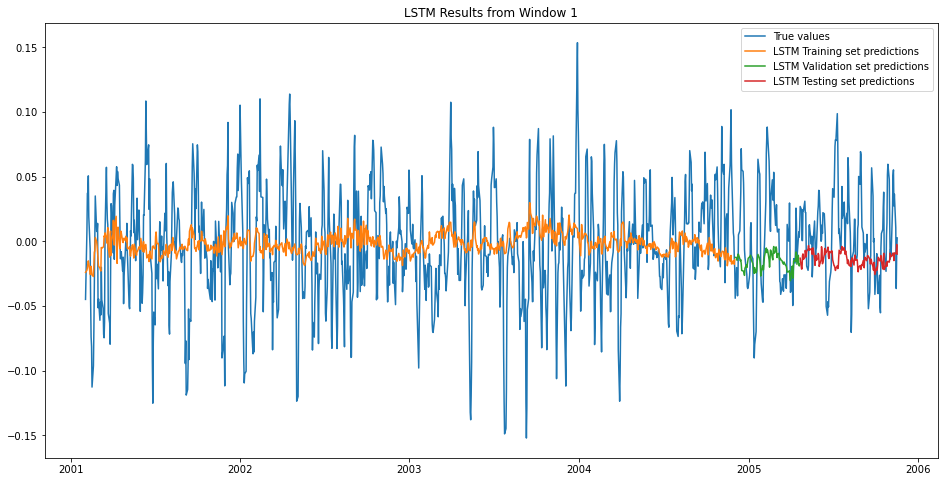

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.001529707365494962
RMSE = 0.039111473578669495
MAE = 0.029687168376627448
R-Squared = 0.17547373054966497

Results on Validation set: 
MSE = 0.0012304610676100128
RMSE = 0.035077928496563375
MAE = 0.027323174662906003
R-Squared = -0.06486060584393516

Results on Testing set: 
MSE = 0.0025375749402666587
RMSE = 0.05037434803813007
MAE = 0.03875365472125849
R-Squared = -0.3077568329782039



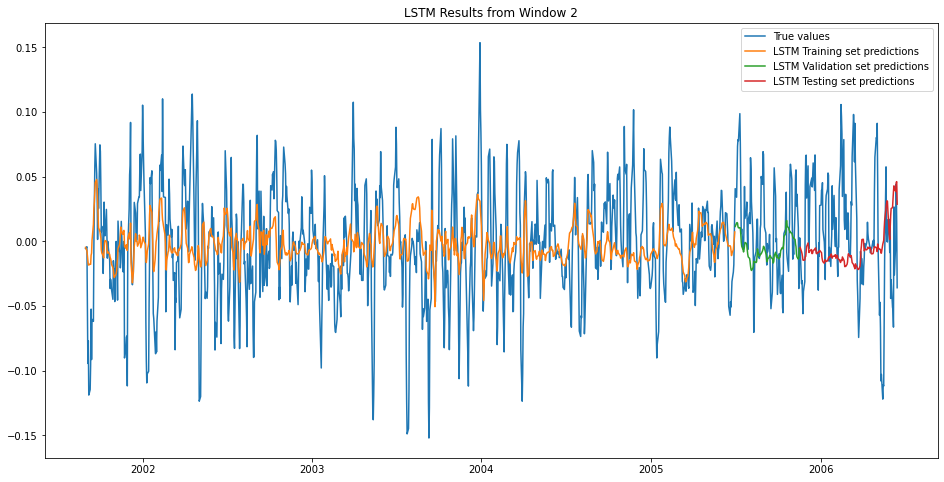

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0017252150815994555
RMSE = 0.041535708512067726
MAE = 0.031954881101168085
R-Squared = -0.025567239349527204

Results on Validation set: 
MSE = 0.0024939590665458843
RMSE = 0.04993955412842494
MAE = 0.03691369466281175
R-Squared = -0.08863339298266437

Results on Testing set: 
MSE = 0.0021239988318097064
RMSE = 0.04608686181342473
MAE = 0.0347875612086443
R-Squared = -0.149307488578174



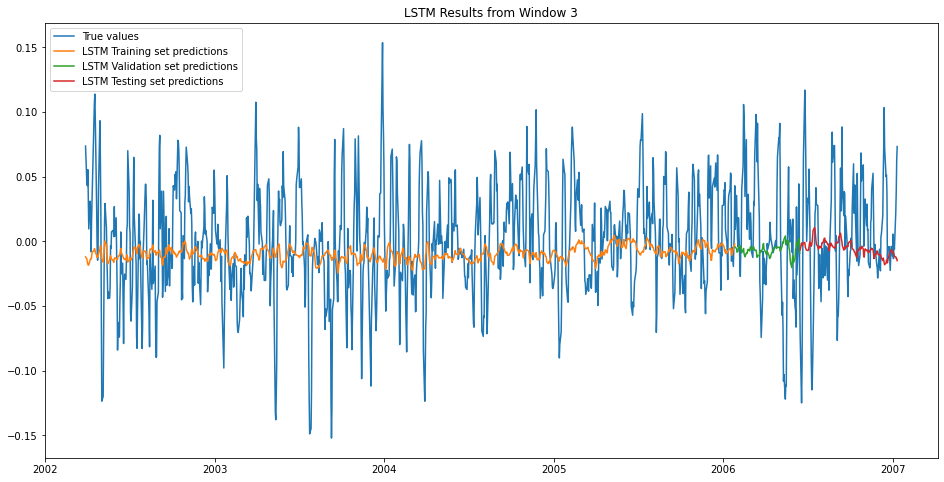

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0012080860891846039
RMSE = 0.03475753284087643
MAE = 0.02583744924675867
R-Squared = 0.3048608855604811

Results on Validation set: 
MSE = 0.0012028312435605087
RMSE = 0.03468185755637245
MAE = 0.02678635010763781
R-Squared = -0.006371957423039198

Results on Testing set: 
MSE = 0.001870113565555371
RMSE = 0.04324480969498387
MAE = 0.035597091942620146
R-Squared = -0.2965577834024129



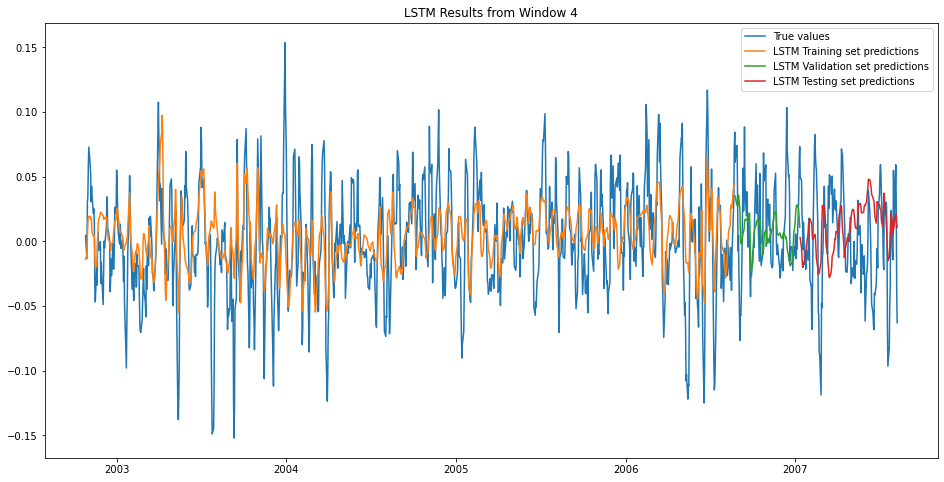

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0020702174805372424
RMSE = 0.04549964264186305
MAE = 0.03547566097695453
R-Squared = -0.1950430025860126

Results on Validation set: 
MSE = 0.0012070246820055064
RMSE = 0.034742260749777154
MAE = 0.028303962003595976
R-Squared = -0.012320765500456465

Results on Testing set: 
MSE = 0.002815490651091144
RMSE = 0.05306119722632673
MAE = 0.04130782796311301
R-Squared = -0.1660499994399851



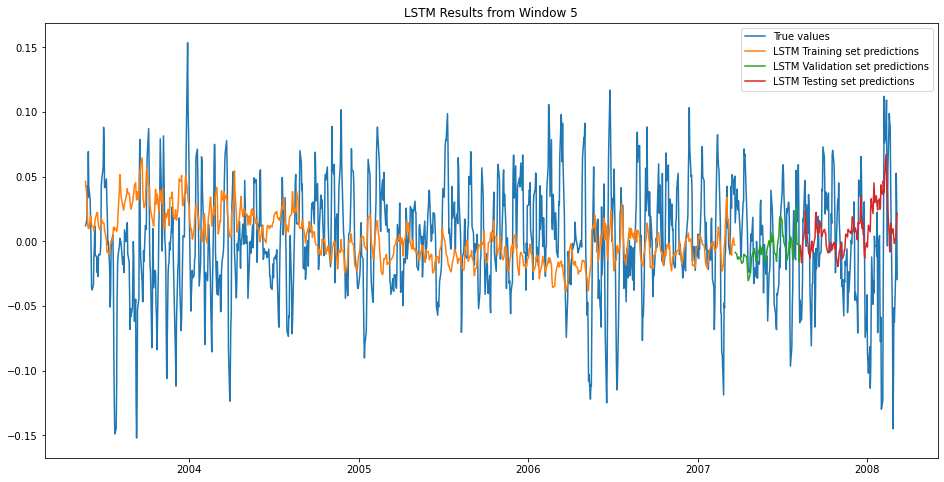

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.00037759413002651075
RMSE = 0.0194317814424337
MAE = 0.014896973312007088
R-Squared = 0.7551558977781276

Results on Validation set: 
MSE = 0.00262157166296278
RMSE = 0.0512012857549767
MAE = 0.036927069427995125
R-Squared = 0.10264491318711266

Results on Testing set: 
MSE = 0.004101997580385811
RMSE = 0.06404683895701498
MAE = 0.052413310095731434
R-Squared = -0.7643389866676369



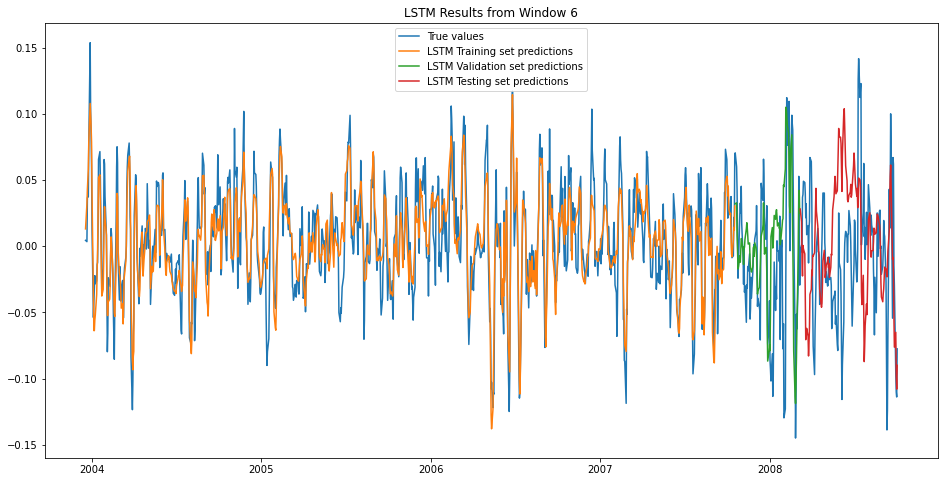

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.001058153042876949
RMSE = 0.032529264407252574
MAE = 0.024552080984981323
R-Squared = 0.3645127065952005

Results on Validation set: 
MSE = 0.0025095826864151177
RMSE = 0.05009573521184331
MAE = 0.03827816757912389
R-Squared = 0.11659839812714157

Results on Testing set: 
MSE = 0.005142675425762342
RMSE = 0.07171244958696044
MAE = 0.0564212239351487
R-Squared = -0.13279230760282323



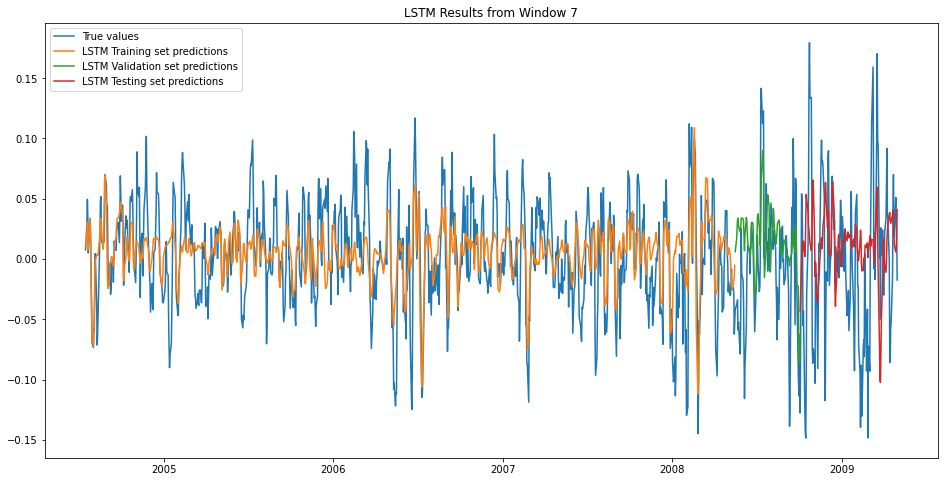

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0018141849050884525
RMSE = 0.04259324952487721
MAE = 0.03190202089150758
R-Squared = 0.11395953471093379

Results on Validation set: 
MSE = 0.0034985843514887304
RMSE = 0.05914883220731184
MAE = 0.04559689115731525
R-Squared = 0.011457371586519272

Results on Testing set: 
MSE = 0.001424444224322235
RMSE = 0.03774181002975659
MAE = 0.029578636607322822
R-Squared = -0.0022855591215011906



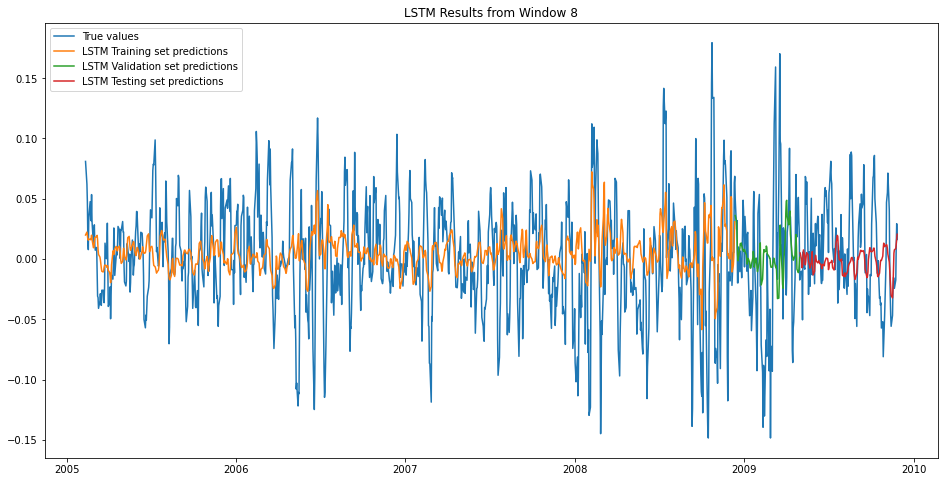

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0019727533783897703
RMSE = 0.04441568842638567
MAE = 0.034433935065541064
R-Squared = 0.14915976490770233

Results on Validation set: 
MSE = 0.0011254824582103593
RMSE = 0.03354821095394447
MAE = 0.025598836497414786
R-Squared = 0.26479903885331235

Results on Testing set: 
MSE = 0.0009453942650483105
RMSE = 0.030747264350642813
MAE = 0.0243643682704166
R-Squared = -0.21334691660416438



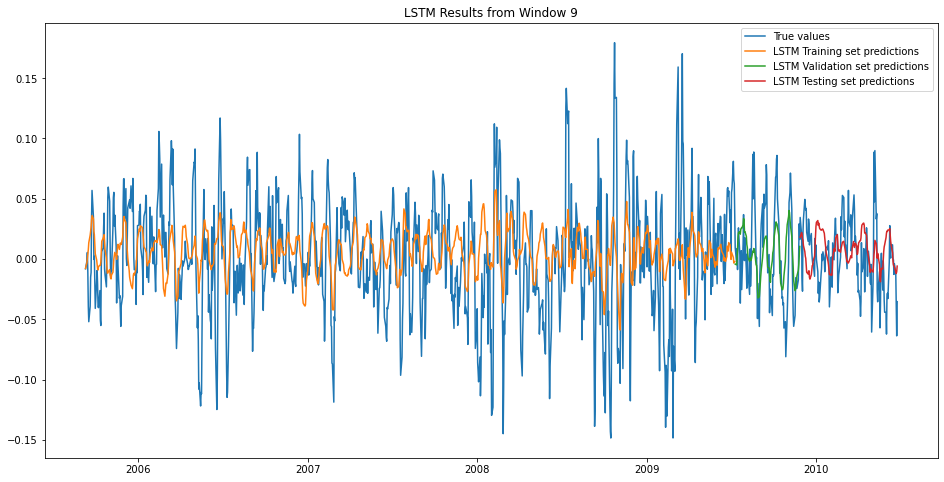

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.002036726262502026
RMSE = 0.04513010372802201
MAE = 0.034207115481812614
R-Squared = 0.10597778644495215

Results on Validation set: 
MSE = 0.0009010957532428606
RMSE = 0.030018256998747623
MAE = 0.023705012362269427
R-Squared = 0.04574112217207438

Results on Testing set: 
MSE = 0.0010496498349036492
RMSE = 0.03239829987674738
MAE = 0.024833764822139667
R-Squared = -0.18084511907924394



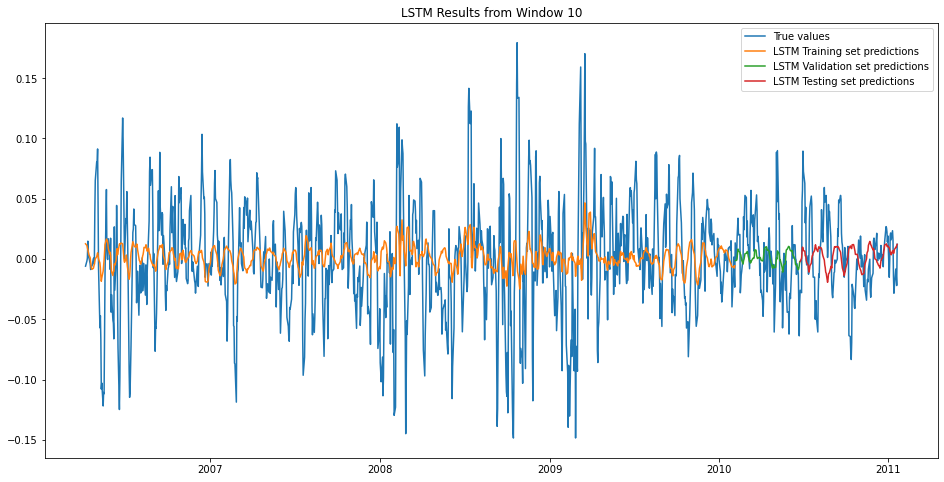

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.001980962553733488
RMSE = 0.044508005501634064
MAE = 0.03348521178024737
R-Squared = 0.051978969919736606

Results on Validation set: 
MSE = 0.0006893725771936862
RMSE = 0.026255905567961015
MAE = 0.0186801651446418
R-Squared = -0.1297917988972721

Results on Testing set: 
MSE = 0.0010109146783419377
RMSE = 0.031794884468133194
MAE = 0.024211688928578844
R-Squared = 0.011780598399564468



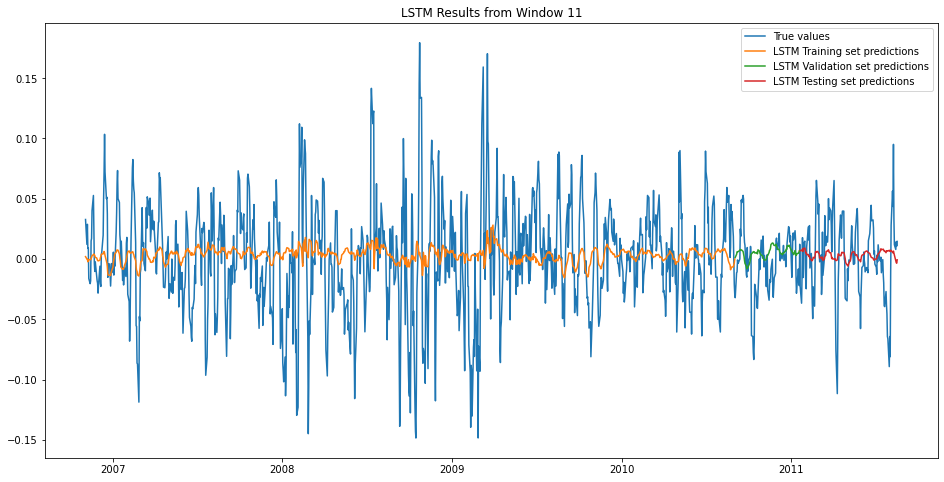

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.001839403779725977
RMSE = 0.042888270887574576
MAE = 0.03187909968487737
R-Squared = 0.08169663044803199

Results on Validation set: 
MSE = 0.0011025402873116334
RMSE = 0.03320452209130006
MAE = 0.02553059486930961
R-Squared = 0.035843953963034636

Results on Testing set: 
MSE = 0.0006991445706595021
RMSE = 0.026441342073720505
MAE = 0.021660318879525665
R-Squared = -0.2553739587457109



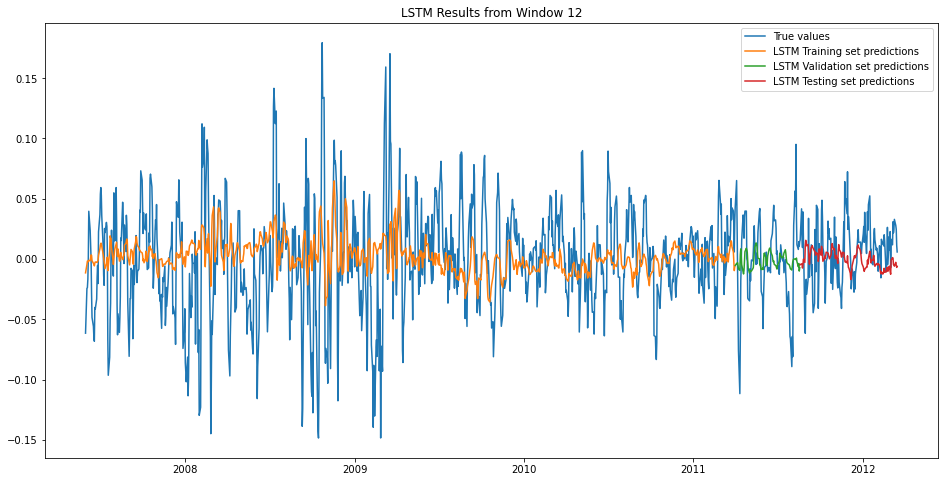

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.001771750848368853
RMSE = 0.042092170867856805
MAE = 0.030938017107490303
R-Squared = 0.0896718245179311

Results on Validation set: 
MSE = 0.0005043283174084673
RMSE = 0.022457255340055857
MAE = 0.017587868152019556
R-Squared = -0.11769985362439228

Results on Testing set: 
MSE = 0.0005855899444413376
RMSE = 0.024198965772142776
MAE = 0.01910317106138476
R-Squared = 0.014431246021486932



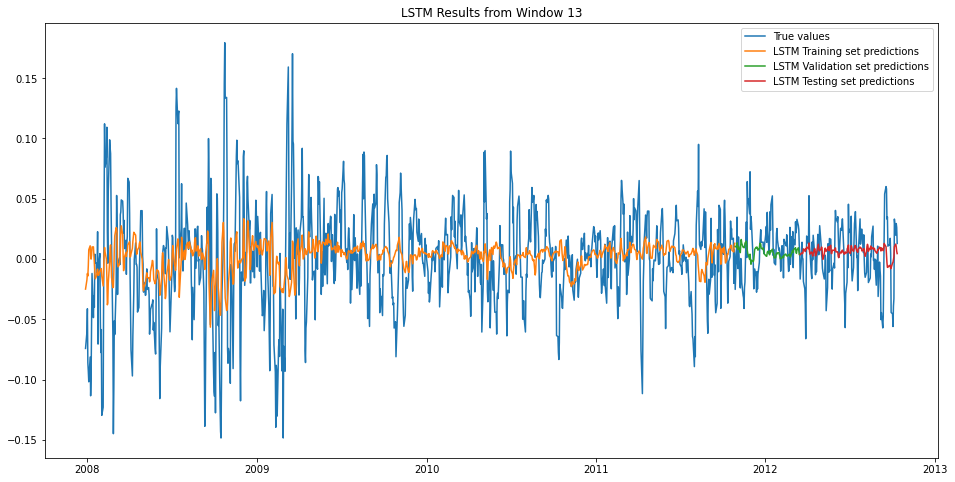

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.000549090331902761
RMSE = 0.023432676584264997
MAE = 0.017535740644492117
R-Squared = 0.6463426525637399

Results on Validation set: 
MSE = 0.0005093442630797821
RMSE = 0.022568656652086808
MAE = 0.018300037613440897
R-Squared = 0.2644431476478539

Results on Testing set: 
MSE = 0.00041459257517496856
RMSE = 0.020361546482891926
MAE = 0.01660180274614737
R-Squared = -0.01903837170706857



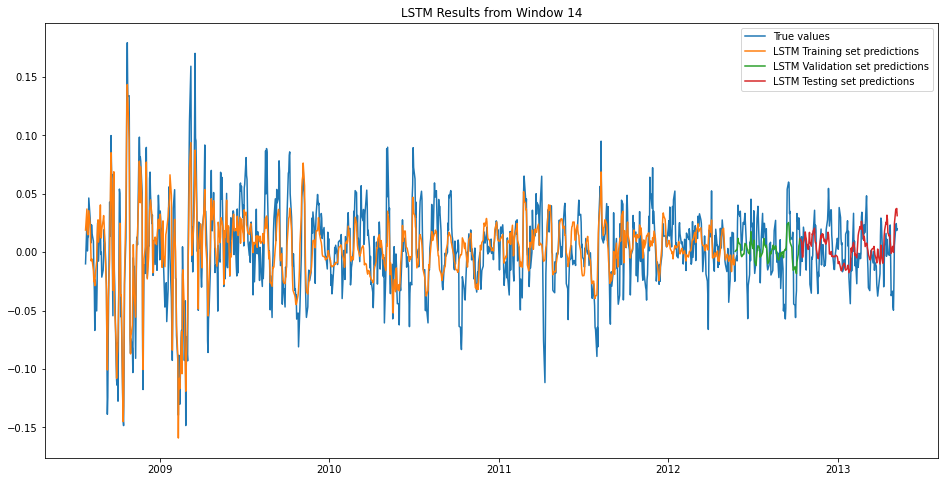

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.000984178564858456
RMSE = 0.031371620373491324
MAE = 0.023532567341593886
R-Squared = 0.04716013752792092

Results on Validation set: 
MSE = 0.0003813003205475154
RMSE = 0.019526912724430235
MAE = 0.015428578712441863
R-Squared = 0.05446112381050716

Results on Testing set: 
MSE = 0.0005909246871403988
RMSE = 0.02430894253439254
MAE = 0.019527569189172405
R-Squared = 0.03605296354723919



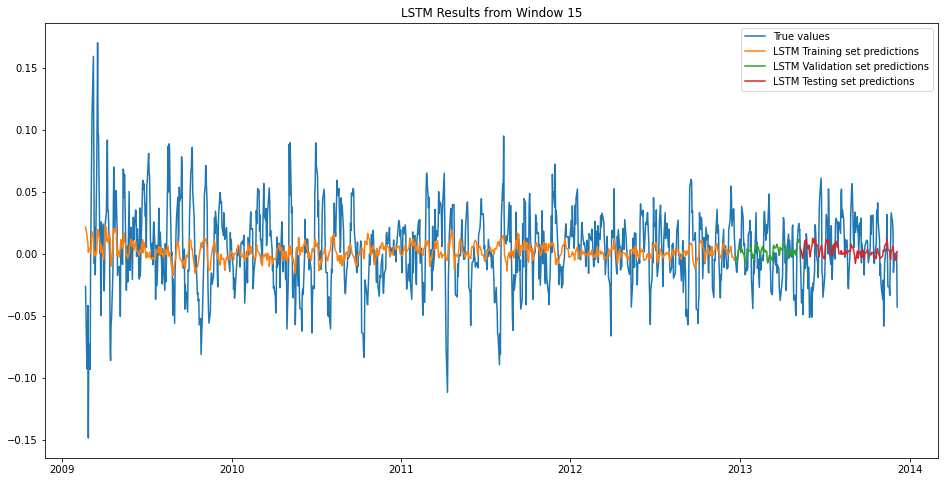

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0007117452185373958
RMSE = 0.0266785535315803
MAE = 0.020339338955916966
R-Squared = 0.0795210533604036

Results on Validation set: 
MSE = 0.00043686821395795566
RMSE = 0.02090139263202229
MAE = 0.016522021548054055
R-Squared = 0.0884114351556653

Results on Testing set: 
MSE = 0.0007209848436835588
RMSE = 0.026851160937351643
MAE = 0.021657100068139562
R-Squared = 0.056205931227284345



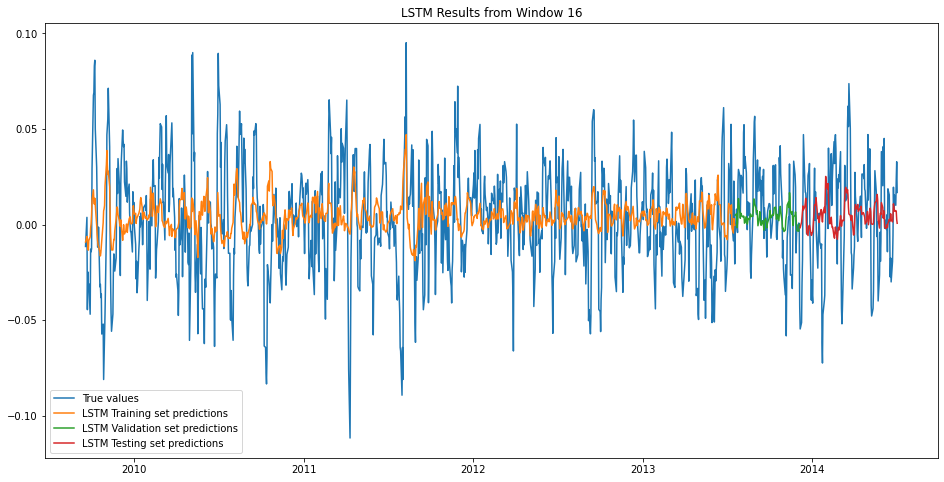

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.00033434582945031485
RMSE = 0.018285125907423084
MAE = 0.013946057153303975
R-Squared = 0.5329149586801372

Results on Validation set: 
MSE = 0.000569649877009138
RMSE = 0.023867339127123872
MAE = 0.018542272265420857
R-Squared = 0.18455338050859804

Results on Testing set: 
MSE = 0.0008031081649535801
RMSE = 0.028339163095504074
MAE = 0.02332760242958443
R-Squared = -0.08465414339347443



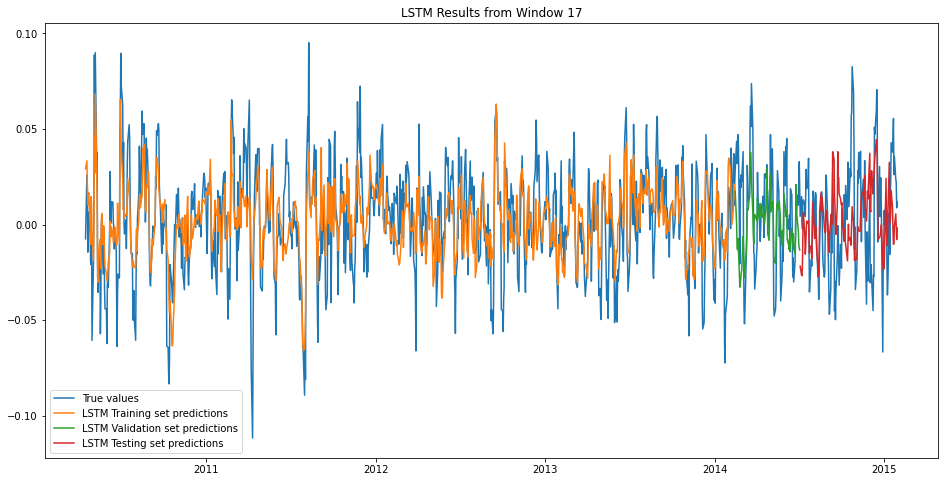

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0004686737739558003
RMSE = 0.02164887465795394
MAE = 0.016389583436062758
R-Squared = 0.2608270962859387

Results on Validation set: 
MSE = 0.0008352951058682652
RMSE = 0.02890147238235909
MAE = 0.02309475571693696
R-Squared = 0.04980919638138137

Results on Testing set: 
MSE = 0.0011046128781911095
RMSE = 0.033235716905027184
MAE = 0.027048945153419754
R-Squared = -0.5601290894580977



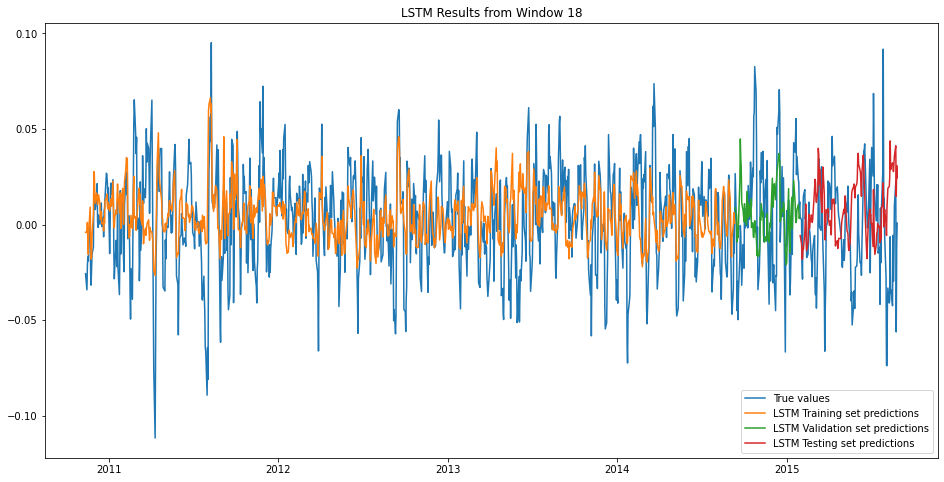

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.00041020851630152124
RMSE = 0.020253605019885258
MAE = 0.015691081787463357
R-Squared = 0.36218680463829445

Results on Validation set: 
MSE = 0.0008642643983992944
RMSE = 0.029398374077477387
MAE = 0.02279327628550256
R-Squared = -0.057793967409893954

Results on Testing set: 
MSE = 0.003539028861034697
RMSE = 0.05948973744298001
MAE = 0.04491882381023842
R-Squared = -0.575924809017577



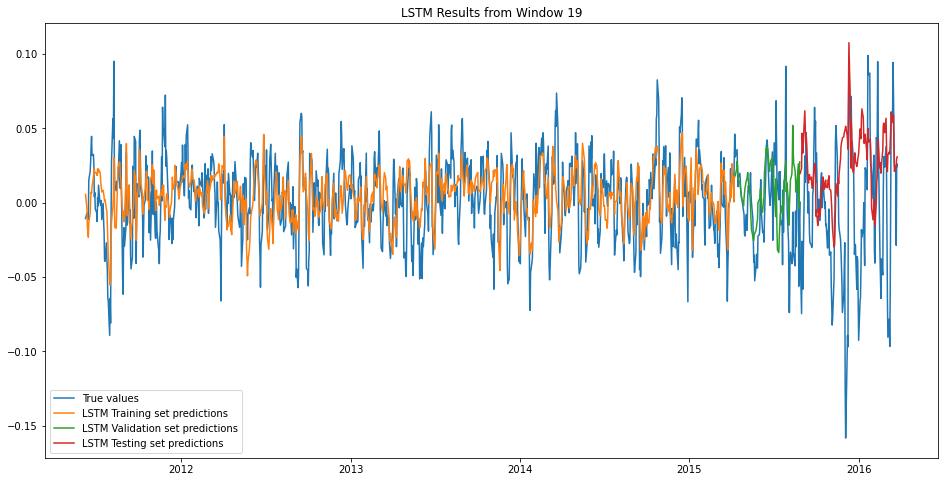

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.00045353261821219566
RMSE = 0.02129630527138911
MAE = 0.016575607071866626
R-Squared = 0.3029752400315999

Results on Validation set: 
MSE = 0.0032554959432515135
RMSE = 0.05705695350482282
MAE = 0.043971728392515945
R-Squared = -0.13493888463175452

Results on Testing set: 
MSE = 0.0014913431933712333
RMSE = 0.038617912856228176
MAE = 0.030876114049397618
R-Squared = -0.01788607417069965



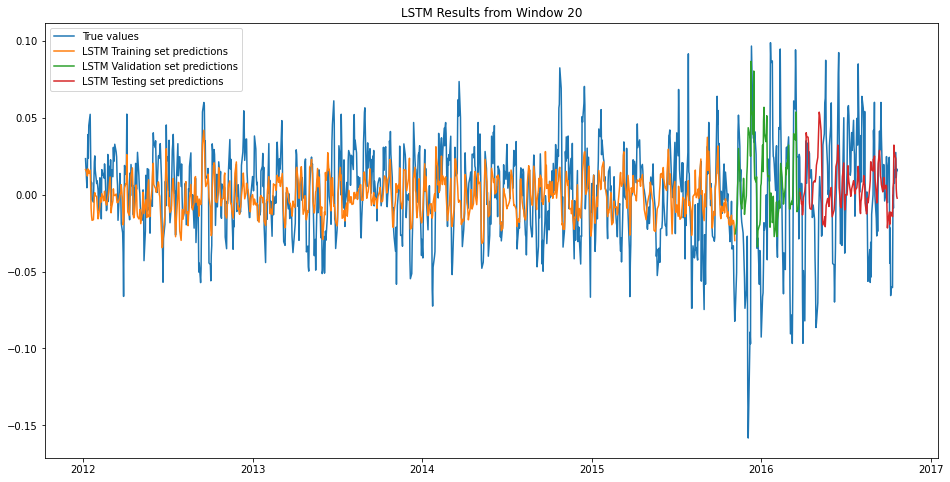

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0009598582869780271
RMSE = 0.03098157980119844
MAE = 0.023265084853580618
R-Squared = 0.0019587510931385888

Results on Validation set: 
MSE = 0.0013134771712842203
RMSE = 0.03624192560121799
MAE = 0.029658962643380443
R-Squared = 0.007384681486640954

Results on Testing set: 
MSE = 0.0014579063173234352
RMSE = 0.03818253942999909
MAE = 0.027874893044445247
R-Squared = -0.17304269411236906



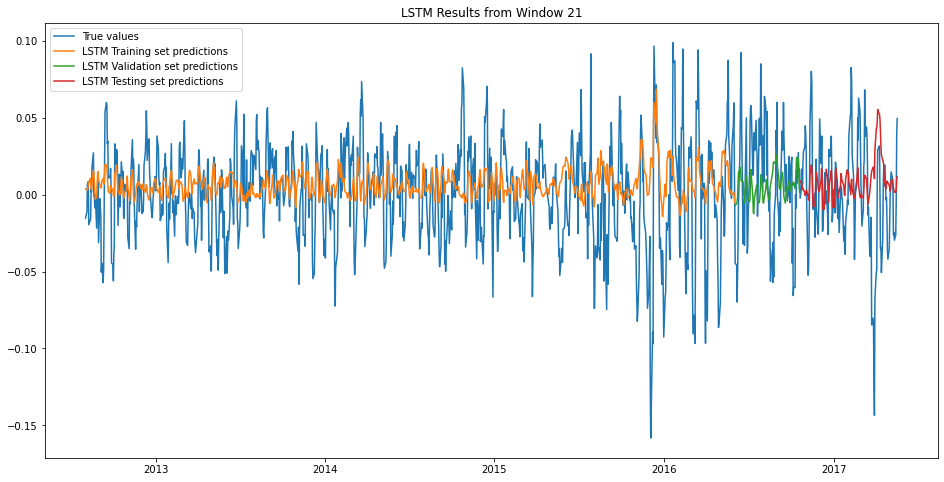

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0009098632116355639
RMSE = 0.03016393892772567
MAE = 0.023215015499016646
R-Squared = 0.14641194835849192

Results on Validation set: 
MSE = 0.0015742163911740624
RMSE = 0.039676395894461765
MAE = 0.02801693894645898
R-Squared = -0.1093009431693368

Results on Testing set: 
MSE = 0.0013135090150446624
RMSE = 0.03624236492069278
MAE = 0.027154114873594988
R-Squared = -0.002264411706008218



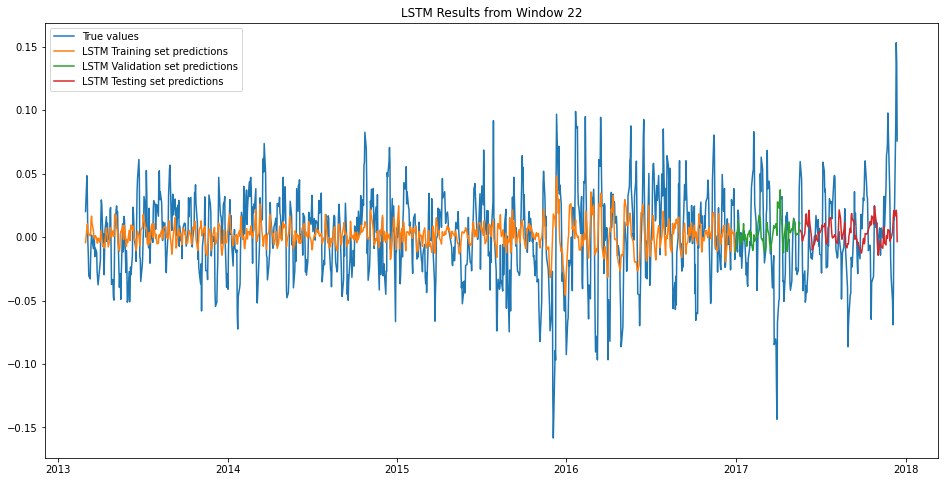

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0012303867429313664
RMSE = 0.035076869058274944
MAE = 0.026672356466717815
R-Squared = -0.06938497550121103

Results on Validation set: 
MSE = 0.001568253800315022
RMSE = 0.03960118432970183
MAE = 0.029126077309471414
R-Squared = 0.018214686862727536

Results on Testing set: 
MSE = 0.001452268855716267
RMSE = 0.038108645419593
MAE = 0.0312436884009731
R-Squared = -0.012086855323059531



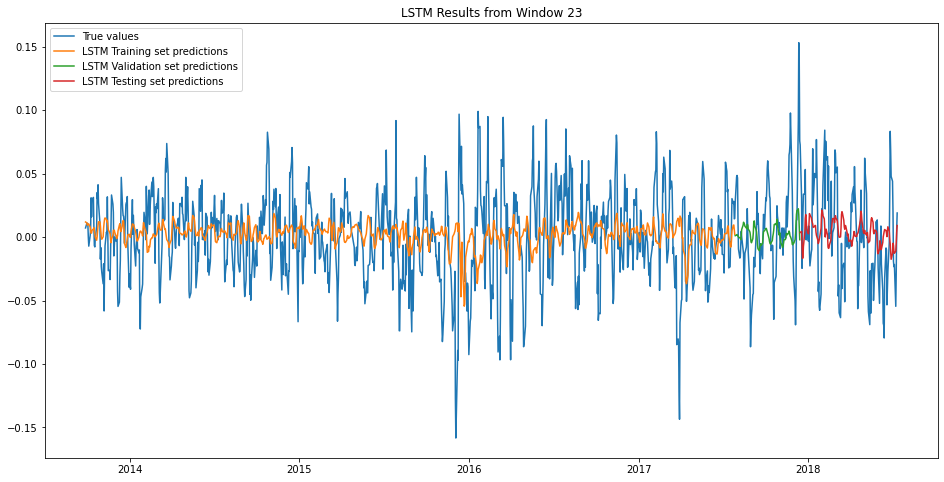

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0009067074156534947
RMSE = 0.030111582749060114
MAE = 0.022858487756218272
R-Squared = 0.2920287222353922

Results on Validation set: 
MSE = 0.0012280880074756553
RMSE = 0.03504408662635759
MAE = 0.028447355322204534
R-Squared = 0.05758301340075089

Results on Testing set: 
MSE = 0.001587437082327126
RMSE = 0.0398426540572679
MAE = 0.031929849624592395
R-Squared = -0.2907226231885145



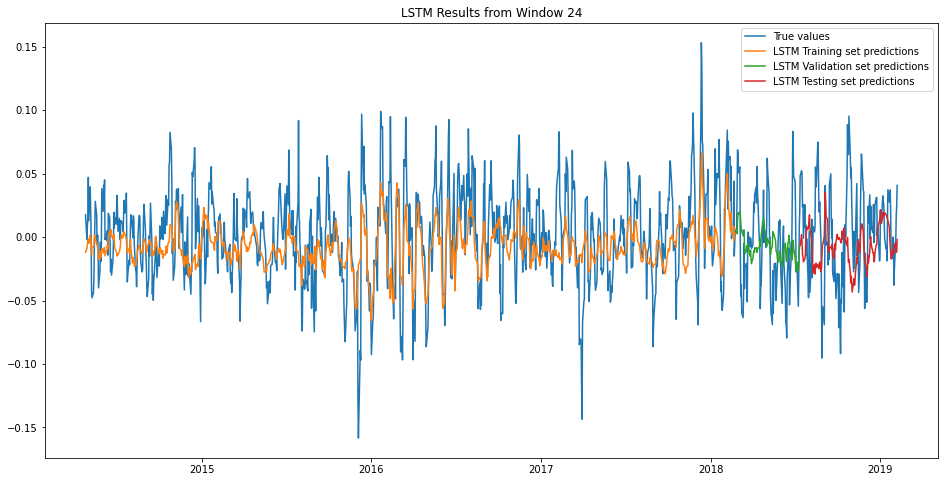

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4927

Results on Training set: 
MSE = 0.0014885839982480206
RMSE = 0.038582172026053956
MAE = 0.029456921339011486
R-Squared = -0.07096373728899352

Results on Validation set: 
MSE = 0.0011229549349849105
RMSE = 0.03351051976596171
MAE = 0.02696299636013542
R-Squared = 0.056402751641008164

Results on Testing set: 
MSE = 0.0013360573216558386
RMSE = 0.03655211788194822
MAE = 0.02983005913252992
R-Squared = -0.06706526746542729



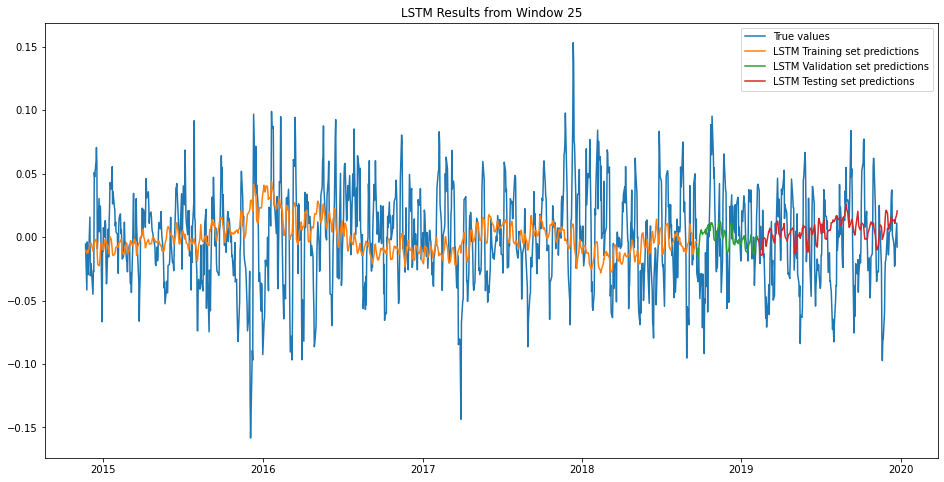

In [7]:
dataset = df.values
totaldatapoints = len(dataset)

#Declaring model parameters
sequencelength = 191
features = len(df.columns) - 1
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
lstm_predictions = np.zeros((numPredictions + extra,1)) 
lstm_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test LSTM
  lstm_model = create_lstm()
  lstm_history, lstm_model = train_lstm(lstm_model, x_train, y_train, x_val, y_val)
  lstm_predictions, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions = makePredictions(lstm_model, lstm_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions)

  lstm_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['LSTM Train Predictions'] = lstm_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['LSTM Val Predictions'] = lstm_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['LSTM Test Predictions'] = lstm_testingPredictions

  #Plot LSTM Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['LSTM Train Predictions'], label = 'LSTM Training set predictions')
  plt.plot(valGraph['LSTM Val Predictions'], label = 'LSTM Validation set predictions')
  plt.plot(testGraph['LSTM Test Predictions'], label = 'LSTM Testing set predictions')
  plt.title("LSTM Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

In [8]:
K.clear_session()
tf.compat.v1.reset_default_graph()

**GRU model**

In [9]:
def create_gru():
  '''
  Function to create an GRU using the Keras Framework
  @returns
    model - Compiled GRU
  '''
  #hyperparameters
  learningRate = 0.00415313472997089
  dropout = 0.011486325079716865
  units = 163

  #Construct GRU
  model = Sequential()
  model.add(GRU(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(GRU(units=units, dropout=dropout))
  model.add(Dense(1))

  #GRU compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_gru(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 106
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./GRU.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./GRU.h5')
  return history, model

**GRU Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0019206921917049131
RMSE = 0.04382570240971516
MAE = 0.03391222731910395
R-Squared = -0.0007432784060172892

Results on Validation set: 
MSE = 0.0016108671777801523
RMSE = 0.040135609846869806
MAE = 0.0336663465594363
R-Squared = 0.00810979216890062

Results on Testing set: 
MSE = 0.0009400393185493909
RMSE = 0.030660060641645687
MAE = 0.02360857220917326
R-Squared = 0.016212575951783714



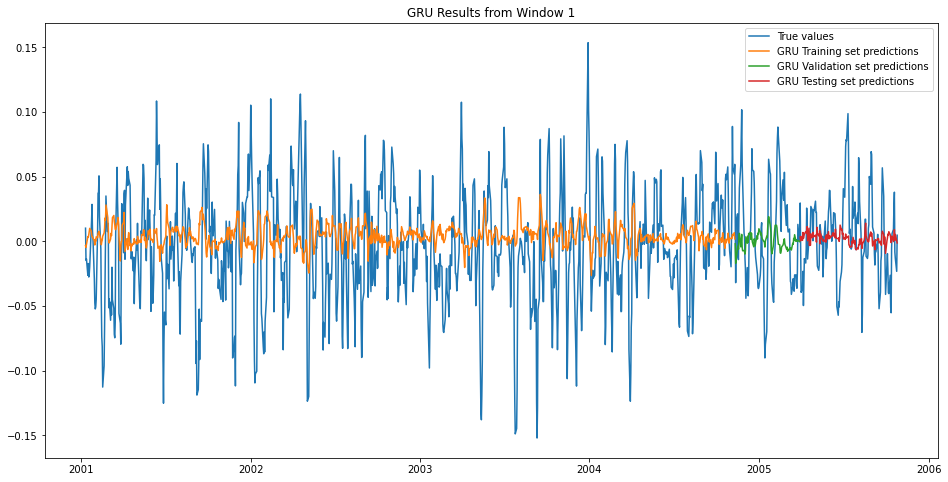

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0018069652122846387
RMSE = 0.04250841342939817
MAE = 0.03260040667893456
R-Squared = 0.023328302437332082

Results on Validation set: 
MSE = 0.001218710812444794
RMSE = 0.03491003884908744
MAE = 0.02679558481227746
R-Squared = -0.008424614369209271

Results on Testing set: 
MSE = 0.0021494483167670574
RMSE = 0.04636214314251507
MAE = 0.035921514758300147
R-Squared = -0.13871604199366572



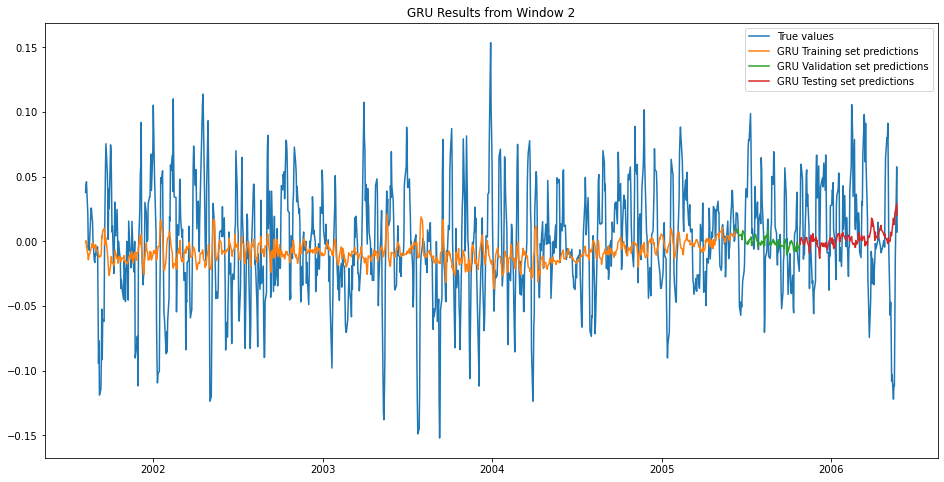

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0015174759638077614
RMSE = 0.03895479384886745
MAE = 0.029683633774860583
R-Squared = 0.10291904493926096

Results on Validation set: 
MSE = 0.0023854427512117774
RMSE = 0.04884099457639839
MAE = 0.037014384375111155
R-Squared = -0.07089925595162283

Results on Testing set: 
MSE = 0.001968947640822513
RMSE = 0.04437282547711508
MAE = 0.03572500221619543
R-Squared = -0.03766839841713332



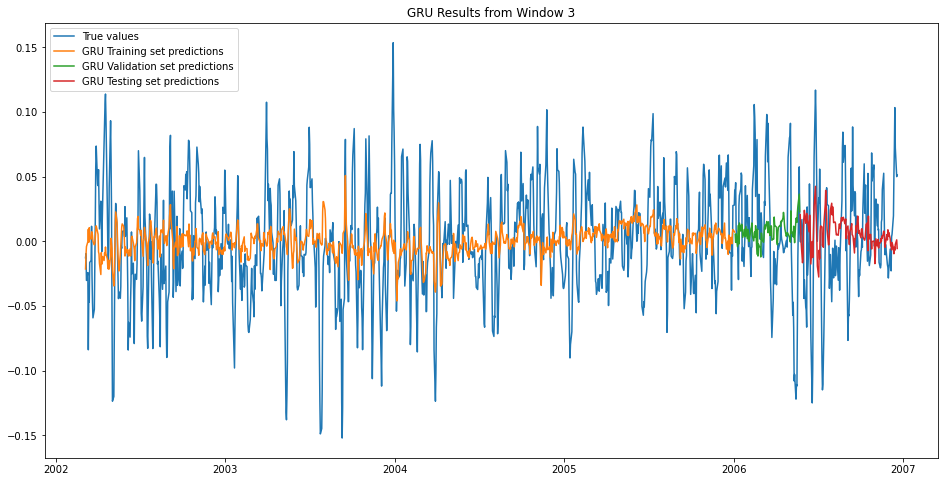

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0013985490140626955
RMSE = 0.0373971792260151
MAE = 0.027779715930849852
R-Squared = 0.20455126128331858

Results on Validation set: 
MSE = 0.0013432864356022428
RMSE = 0.03665087223521758
MAE = 0.02843807444387133
R-Squared = -0.05329925642719324

Results on Testing set: 
MSE = 0.001534216471901917
RMSE = 0.039169075453754545
MAE = 0.03037375149632832
R-Squared = -0.20995273184296726



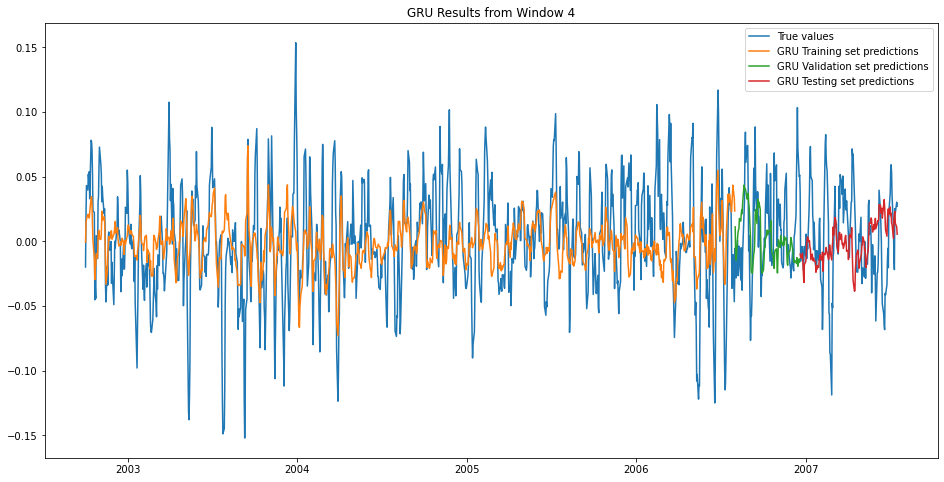

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0017782375066350035
RMSE = 0.042169153496780125
MAE = 0.03203196801278257
R-Squared = 0.004469301008747539

Results on Validation set: 
MSE = 0.001011931904303224
RMSE = 0.031810877138224655
MAE = 0.026200910630786237
R-Squared = -0.04559980986284229

Results on Testing set: 
MSE = 0.002162734841599978
RMSE = 0.04650521305832259
MAE = 0.03724974685407995
R-Squared = -0.017143270617890893



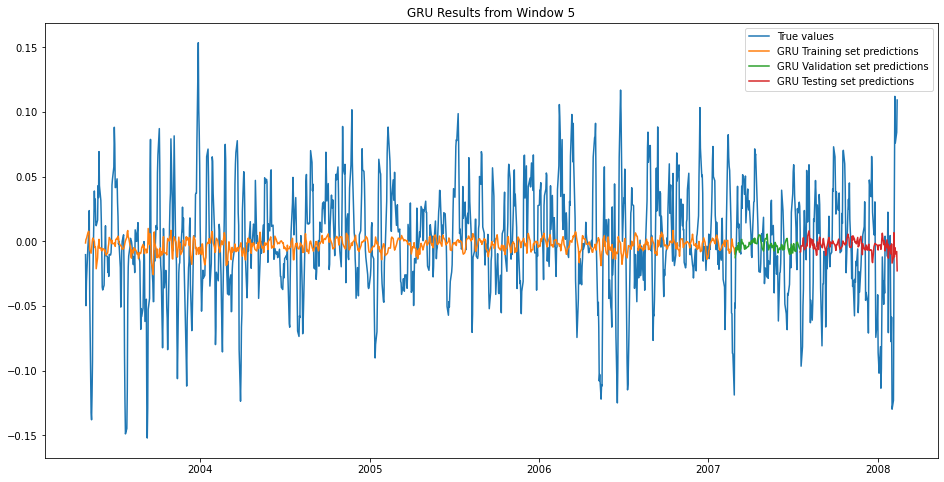

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0016621771303621197
RMSE = 0.04076980660197102
MAE = 0.031855050333889336
R-Squared = -0.05793399792859155

Results on Validation set: 
MSE = 0.002547407443255461
RMSE = 0.050471848026949255
MAE = 0.03956216409147634
R-Squared = -0.031757353098294194

Results on Testing set: 
MSE = 0.0022330088177996495
RMSE = 0.04725472270365841
MAE = 0.03555204856143244
R-Squared = -0.040848440657169194



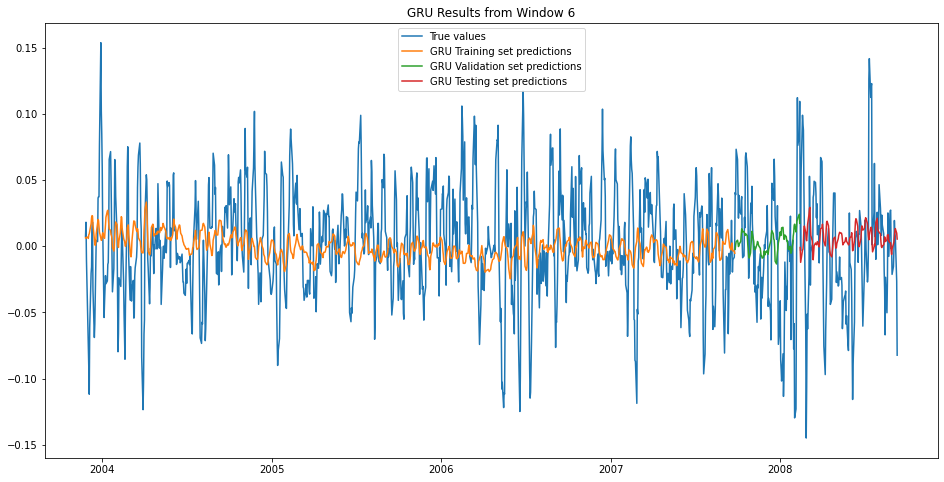

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.001625791608762684
RMSE = 0.04032110624428209
MAE = 0.031237915381598924
R-Squared = 0.024956224929443827

Results on Validation set: 
MSE = 0.001930217626014277
RMSE = 0.04393424206714254
MAE = 0.03192097785161207
R-Squared = -0.008393735278429348

Results on Testing set: 
MSE = 0.005038683227797342
RMSE = 0.07098368282779742
MAE = 0.05651111503598796
R-Squared = -0.014080110106774013



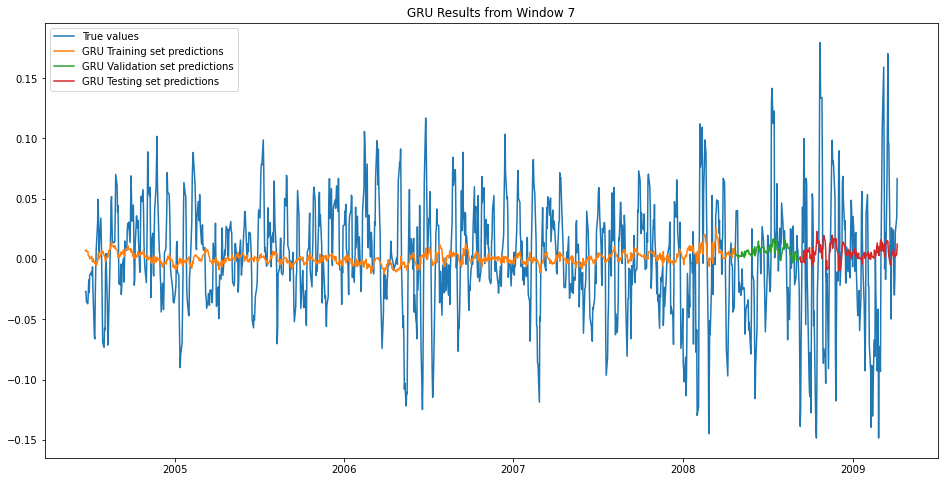

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.001916171609401173
RMSE = 0.04377409747100645
MAE = 0.033123812225980515
R-Squared = 0.048887668823568875

Results on Validation set: 
MSE = 0.003615433576933605
RMSE = 0.06012847559130038
MAE = 0.04696393902729519
R-Squared = 0.056594593389025616

Results on Testing set: 
MSE = 0.0016569520694290913
RMSE = 0.04070567613280845
MAE = 0.03201146654816329
R-Squared = -0.08337568589951805



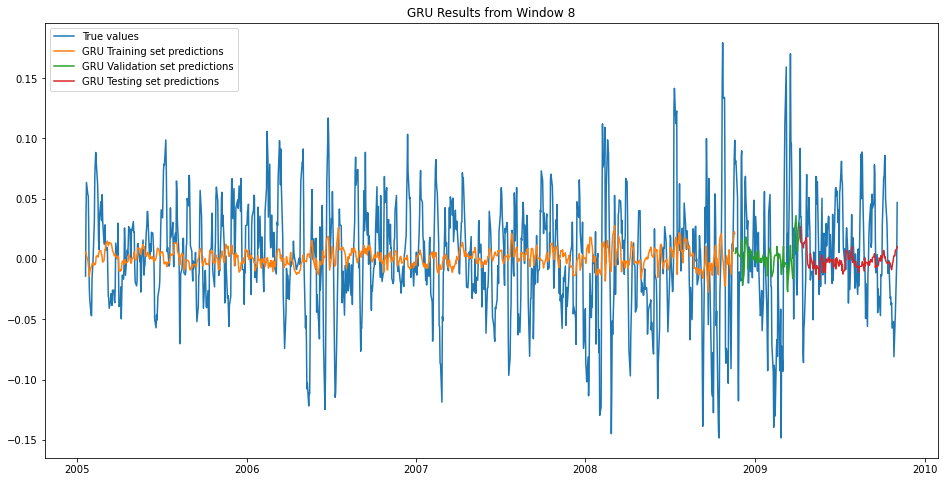

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0008307074731880564
RMSE = 0.028821996342863837
MAE = 0.02221525266336767
R-Squared = 0.6380543685269267

Results on Validation set: 
MSE = 0.0013091458333715125
RMSE = 0.03618212035483151
MAE = 0.02862390507163779
R-Squared = 0.18569866736360774

Results on Testing set: 
MSE = 0.0017522980991807476
RMSE = 0.041860459853909245
MAE = 0.03400903625502592
R-Squared = -1.0487227026747146



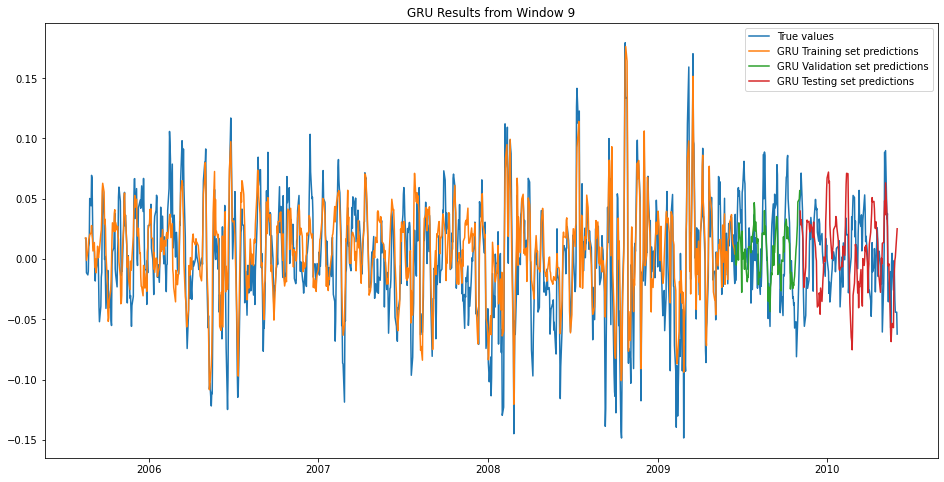

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0025052240405854203
RMSE = 0.05005221314373042
MAE = 0.03842554525314737
R-Squared = -0.08563040290146562

Results on Validation set: 
MSE = 0.0007989677940921896
RMSE = 0.028266018362906892
MAE = 0.02192837981936385
R-Squared = 0.06731937263980281

Results on Testing set: 
MSE = 0.001073245032221043
RMSE = 0.032760418682016915
MAE = 0.025848468883357664
R-Squared = -0.1526622696429858



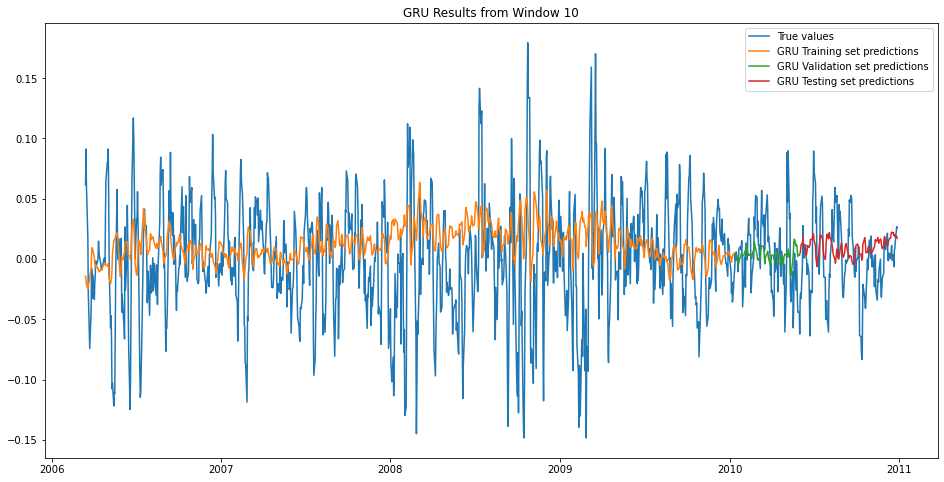

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0020068000758033744
RMSE = 0.04479732219456175
MAE = 0.0335723329573609
R-Squared = 0.04004154565098039

Results on Validation set: 
MSE = 0.000793240145987474
RMSE = 0.028164519274922376
MAE = 0.021150775302095668
R-Squared = -0.022616358959546723

Results on Testing set: 
MSE = 0.0007455090675624023
RMSE = 0.0273040119316265
MAE = 0.021363056773903183
R-Squared = 0.003899658265248185



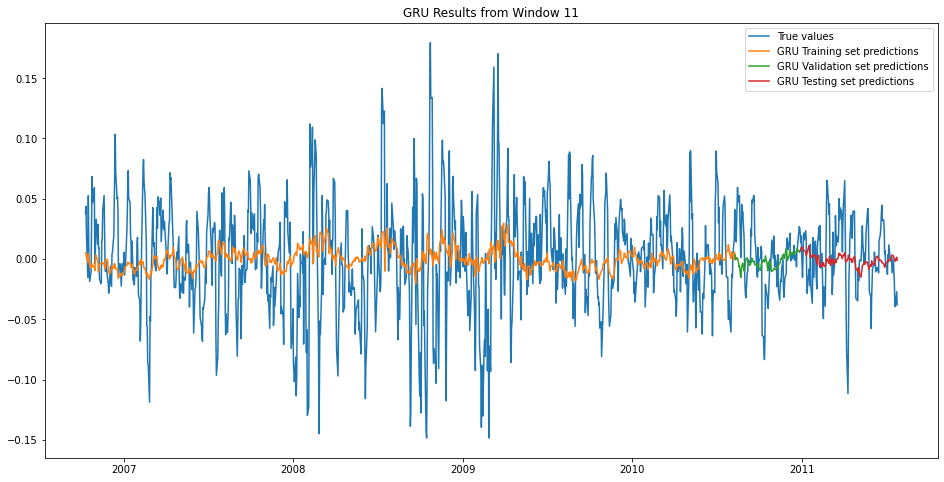

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.0013123081548823779
RMSE = 0.036225794054545964
MAE = 0.027371529153359546
R-Squared = 0.3430606967702492

Results on Validation set: 
MSE = 0.0006982484395868988
RMSE = 0.0264243909974648
MAE = 0.020023594349666374
R-Squared = 0.1324809117185256

Results on Testing set: 
MSE = 0.0012209442155444576
RMSE = 0.03494201218511117
MAE = 0.028287951632642888
R-Squared = -0.4412939331848007



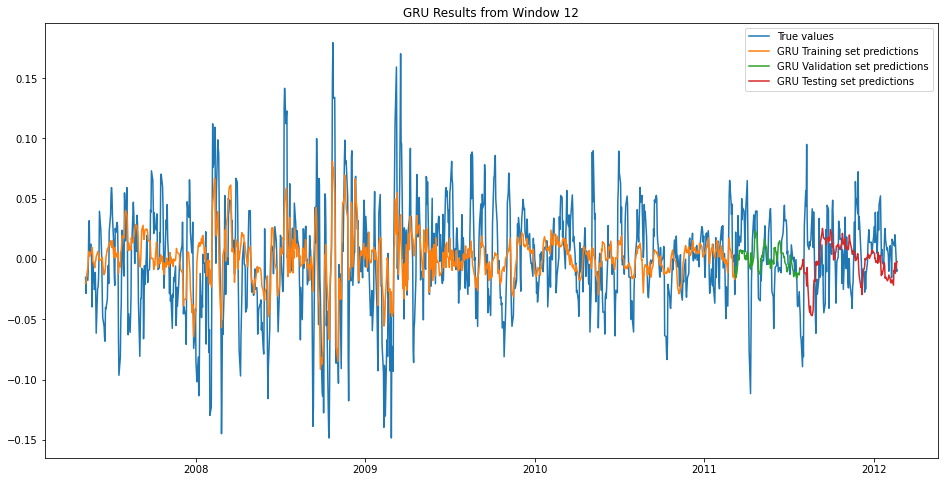

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.001822194720270743
RMSE = 0.042687172783761905
MAE = 0.03156912201611821
R-Squared = 0.0724742610941077

Results on Validation set: 
MSE = 0.0005511146688591872
RMSE = 0.02347583159036517
MAE = 0.018558438620004315
R-Squared = -0.11341695898914694

Results on Testing set: 
MSE = 0.0005347379287748275
RMSE = 0.023124401154945125
MAE = 0.018540177321245112
R-Squared = -0.022015710088777007



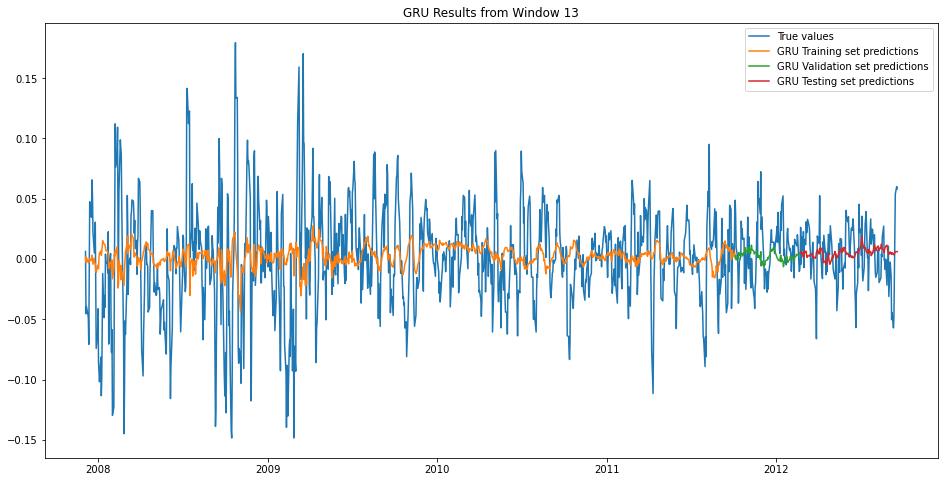

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0009643808254959523
RMSE = 0.03105448156862311
MAE = 0.023396209826893978
R-Squared = 0.40769364835237376

Results on Validation set: 
MSE = 0.0005031822985136382
RMSE = 0.02243172526832562
MAE = 0.017679525278257467
R-Squared = 0.1441929831822225

Results on Testing set: 
MSE = 0.0004456478427870456
RMSE = 0.021110372871814595
MAE = 0.017420668483778295
R-Squared = -0.013263424082390785



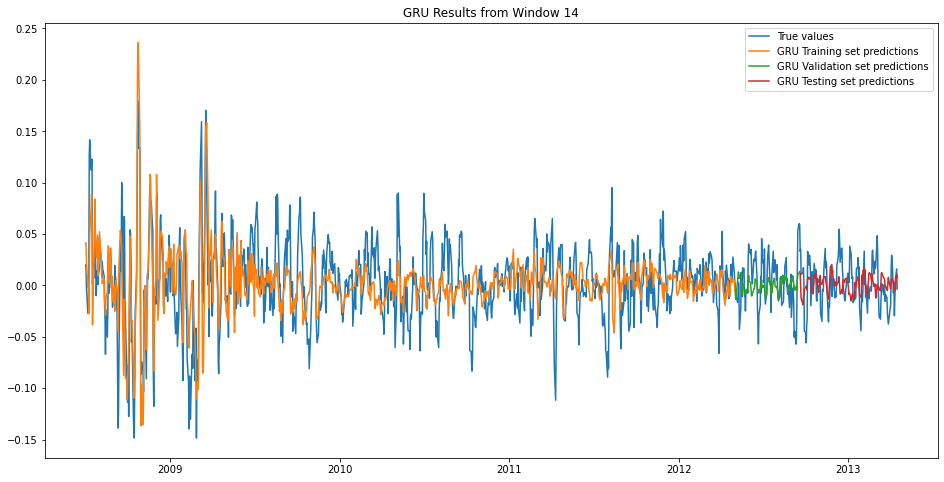

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0009786987908216203
RMSE = 0.031284161980491346
MAE = 0.023028793815826166
R-Squared = 0.13391085009300918

Results on Validation set: 
MSE = 0.00038961907718094817
RMSE = 0.019738770913634622
MAE = 0.016072739731476774
R-Squared = 0.03736233774225339

Results on Testing set: 
MSE = 0.0006697224621295499
RMSE = 0.025878996544100197
MAE = 0.020936731369599955
R-Squared = -0.05816449521138578



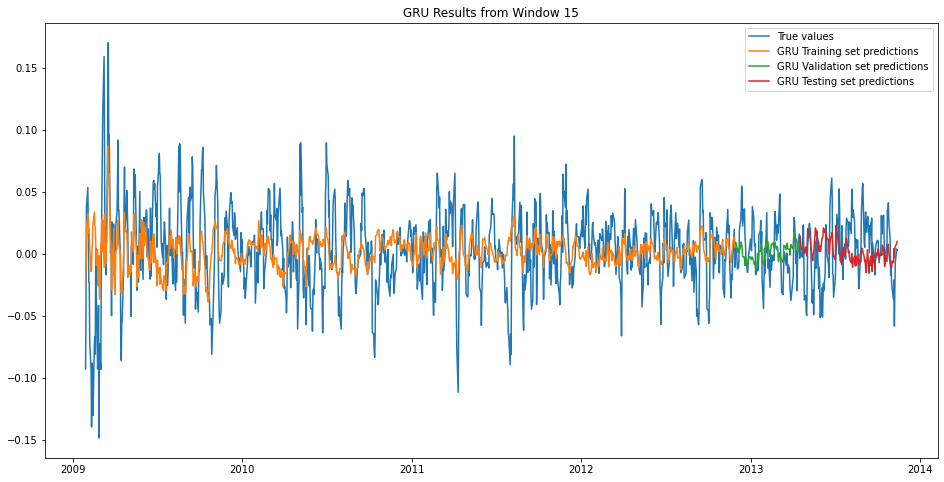

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.000732129108684047
RMSE = 0.027057884408875115
MAE = 0.020759476496799566
R-Squared = 0.07478140790362231

Results on Validation set: 
MSE = 0.000421025759950996
RMSE = 0.020518912250677326
MAE = 0.01636492676314717
R-Squared = 0.12162206500216377

Results on Testing set: 
MSE = 0.0007117934639069216
RMSE = 0.026679457713883945
MAE = 0.021329821273359927
R-Squared = 0.09024882440916193



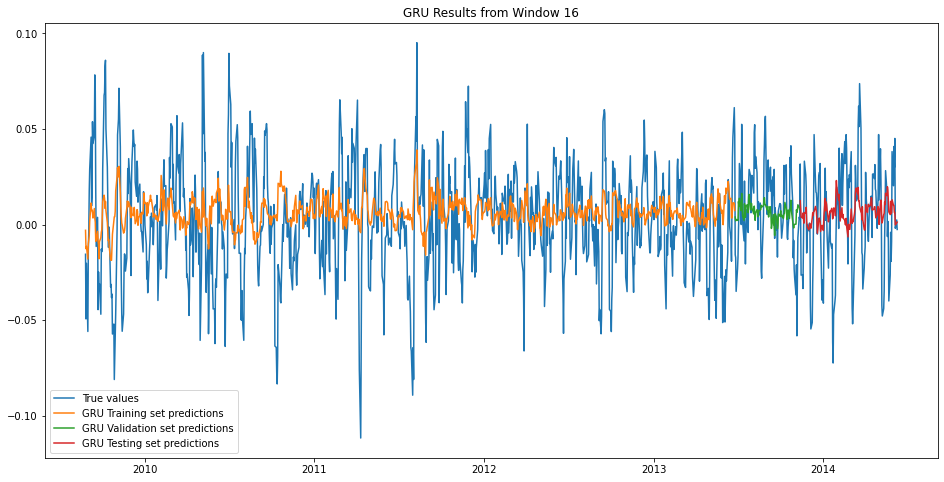

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0002045298314280774
RMSE = 0.014301392639462684
MAE = 0.010808976267395692
R-Squared = 0.7102811864203084

Results on Validation set: 
MSE = 0.0006952655999793652
RMSE = 0.026367889562484238
MAE = 0.021008710881751304
R-Squared = 0.18663610652889262

Results on Testing set: 
MSE = 0.0008799155430511285
RMSE = 0.029663370392642986
MAE = 0.0239879945064068
R-Squared = -0.2857268556356831



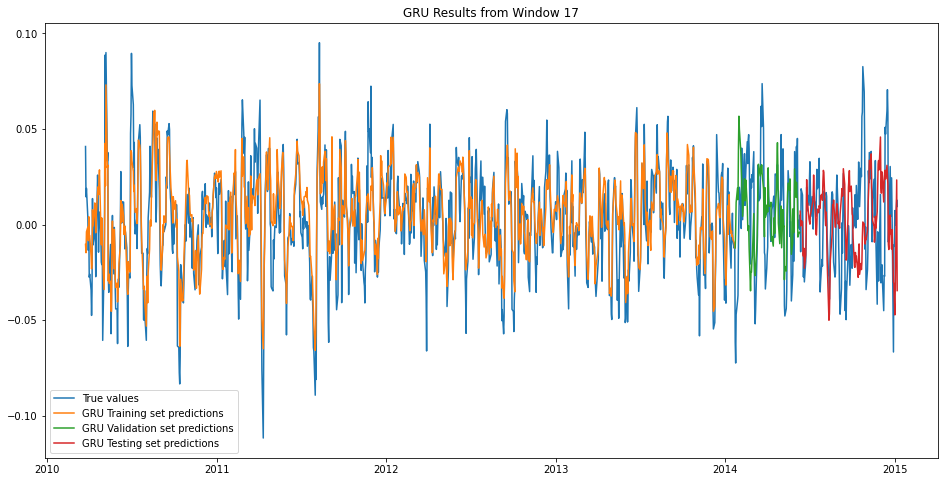

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0005454409273260004
RMSE = 0.023354676776311856
MAE = 0.017924702730404748
R-Squared = 0.13501554001891336

Results on Validation set: 
MSE = 0.0007491202293875685
RMSE = 0.02737006082177328
MAE = 0.02205465806862263
R-Squared = 0.11807030147735931

Results on Testing set: 
MSE = 0.0007097319903845337
RMSE = 0.026640795603444987
MAE = 0.02155123768578431
R-Squared = -0.04167611840967145



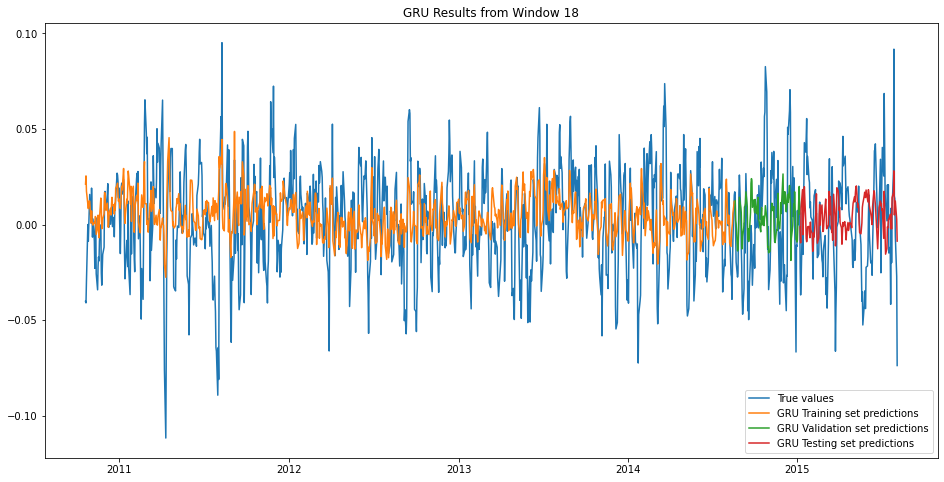

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0006820554514293239
RMSE = 0.02611619136530677
MAE = 0.02080646973682574
R-Squared = -0.06385826153117691

Results on Validation set: 
MSE = 0.0007185448995104663
RMSE = 0.02680568782013374
MAE = 0.02066423150787362
R-Squared = 0.04113860075386022

Results on Testing set: 
MSE = 0.0027621986161948716
RMSE = 0.05255662295272473
MAE = 0.04256419499218096
R-Squared = -0.4189214380987225



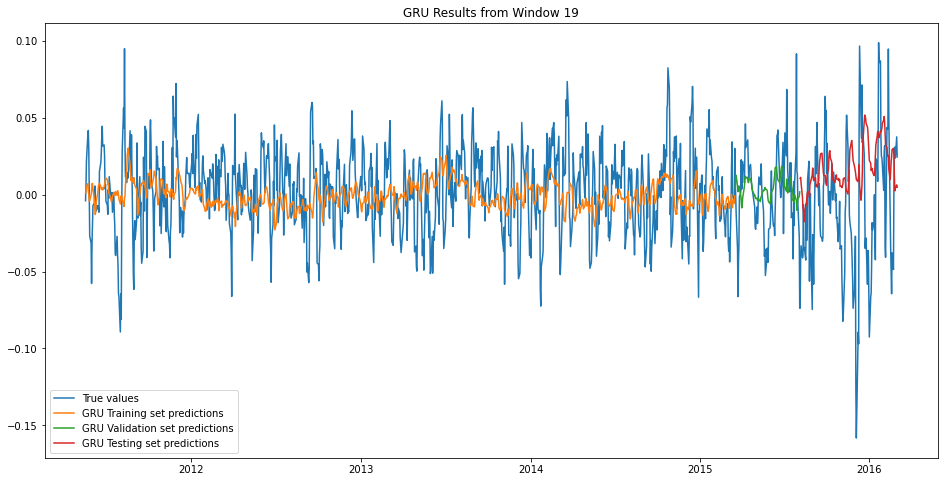

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0005147625251917504
RMSE = 0.022688378637349793
MAE = 0.017527989098707758
R-Squared = 0.18887492609305467

Results on Validation set: 
MSE = 0.002744032154646366
RMSE = 0.05238351033146181
MAE = 0.03934516535537923
R-Squared = -0.13529858095729463

Results on Testing set: 
MSE = 0.002092317202666881
RMSE = 0.04574185394872929
MAE = 0.03676988889930645
R-Squared = -0.20394441712990385



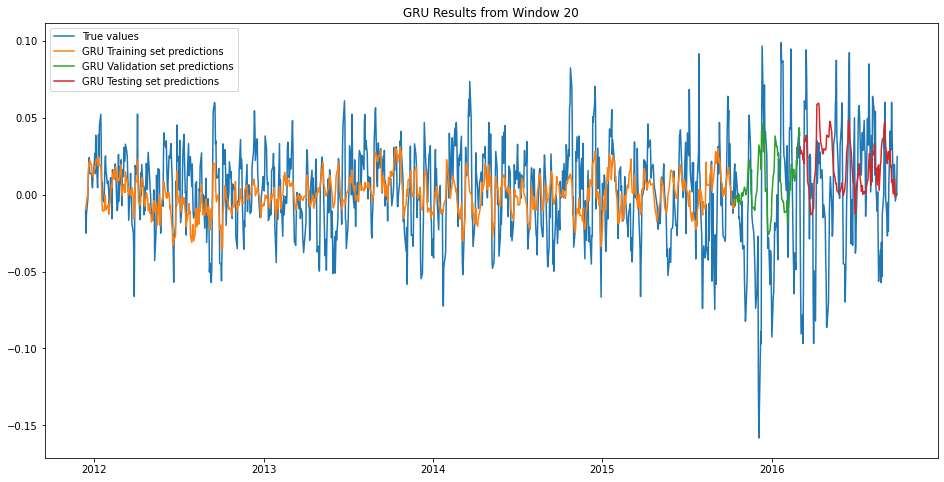

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0008794566884658862
RMSE = 0.029655635020445714
MAE = 0.022452693633889513
R-Squared = 0.06619969121318281

Results on Validation set: 
MSE = 0.0014786253693057222
RMSE = 0.038452898061208884
MAE = 0.033034362330064876
R-Squared = -0.1323540874207374

Results on Testing set: 
MSE = 0.001354774143256792
RMSE = 0.036807256665728184
MAE = 0.02636311249487007
R-Squared = -0.06343478826744775



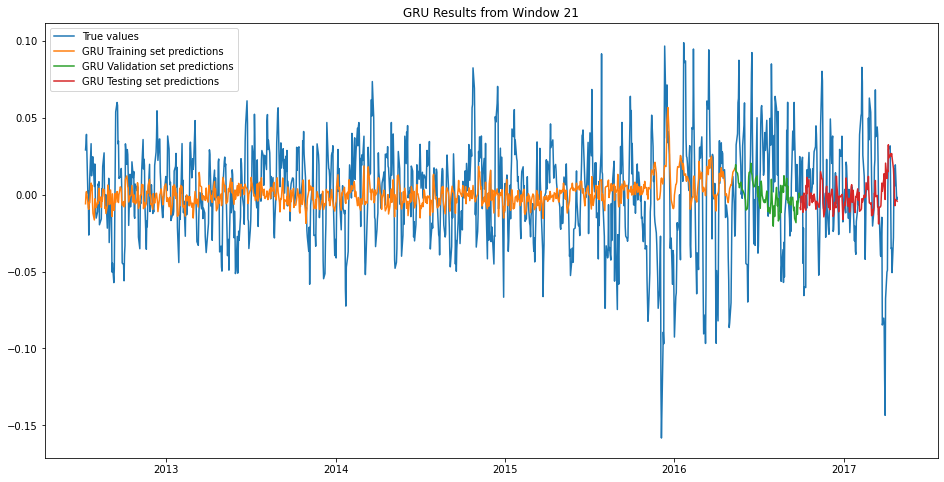

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0002756477676607175
RMSE = 0.01660264339377069
MAE = 0.012603595674505976
R-Squared = 0.7405969684753297

Results on Validation set: 
MSE = 0.001710579676049593
RMSE = 0.041359154682483454
MAE = 0.027082413330421475
R-Squared = -0.23109723633426715

Results on Testing set: 
MSE = 0.0018129143189559672
RMSE = 0.04257833156613781
MAE = 0.033766607358238394
R-Squared = -1.26202557838196



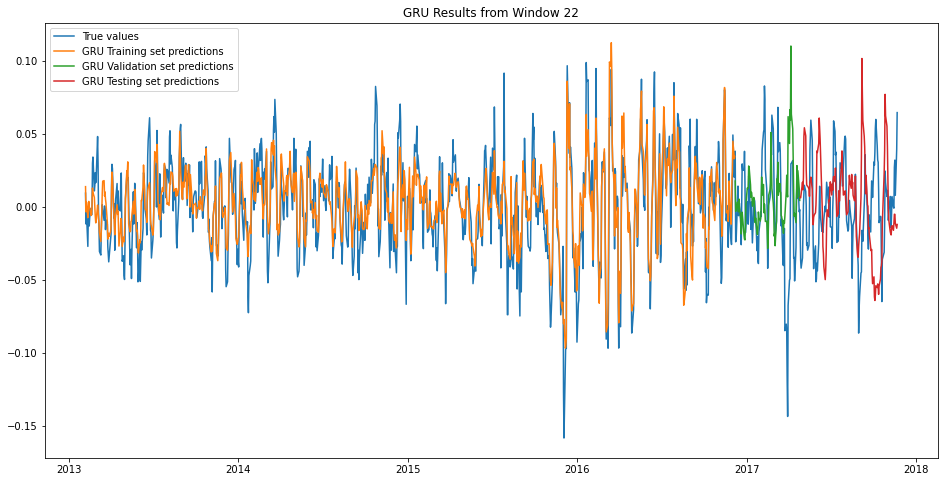

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0012184566301857176
RMSE = 0.034906398126786406
MAE = 0.027047039289012958
R-Squared = -0.06525434588010626

Results on Validation set: 
MSE = 0.0009227013084376263
RMSE = 0.030375998887898752
MAE = 0.023470994270012552
R-Squared = -0.07750128729540373

Results on Testing set: 
MSE = 0.0018793099488264157
RMSE = 0.04335100862524903
MAE = 0.033940932753799676
R-Squared = -0.0309337204831992



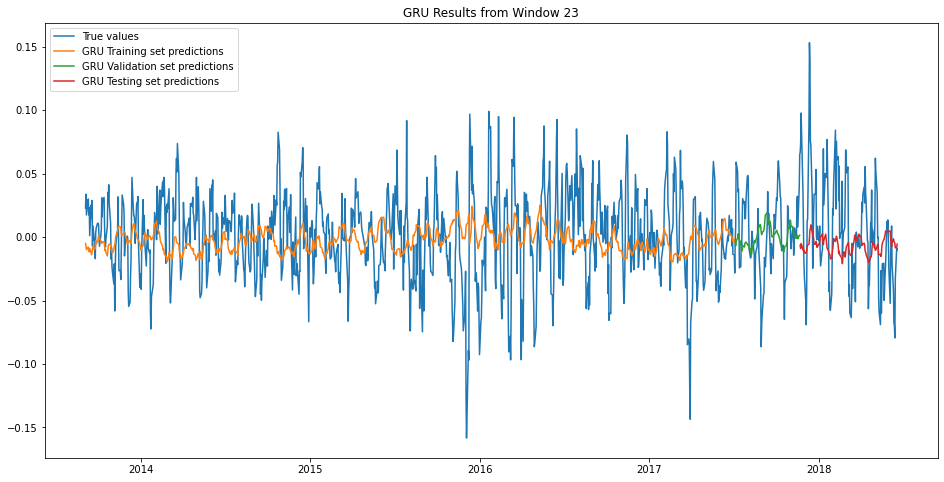

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0007029992729780983
RMSE = 0.026514133457046986
MAE = 0.019497751702132783
R-Squared = 0.4383620665069039

Results on Validation set: 
MSE = 0.001374553833944585
RMSE = 0.03707497584550238
MAE = 0.02941171322209241
R-Squared = 0.02608387499532916

Results on Testing set: 
MSE = 0.001574667568387328
RMSE = 0.039682081200301575
MAE = 0.0317943882862797
R-Squared = -0.16664351514807008



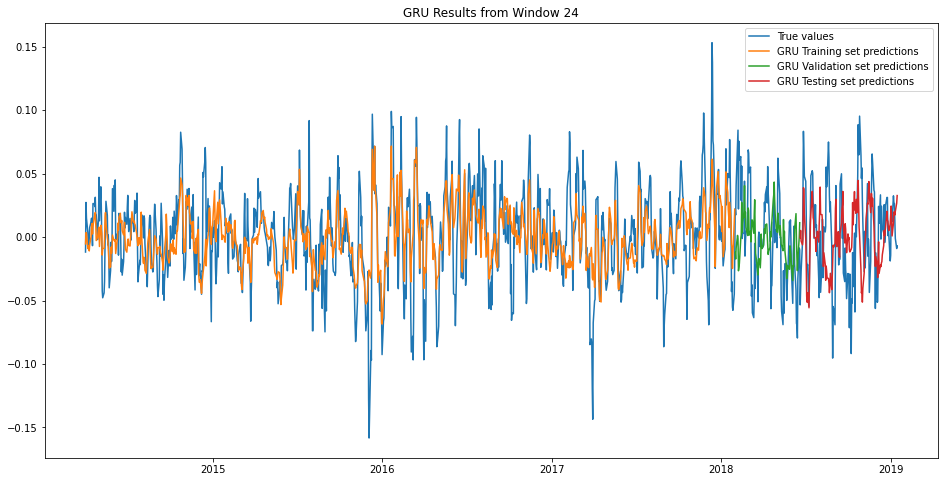

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4944

Results on Training set: 
MSE = 0.00091087197916135
RMSE = 0.03018065571125568
MAE = 0.02274686347802627
R-Squared = 0.3356472494829632

Results on Validation set: 
MSE = 0.0012369927935390837
RMSE = 0.03517090834111459
MAE = 0.028672698026533907
R-Squared = 0.09788970982151479

Results on Testing set: 
MSE = 0.001686409503481752
RMSE = 0.0410659165669263
MAE = 0.03364852535234356
R-Squared = -0.38820362493179594



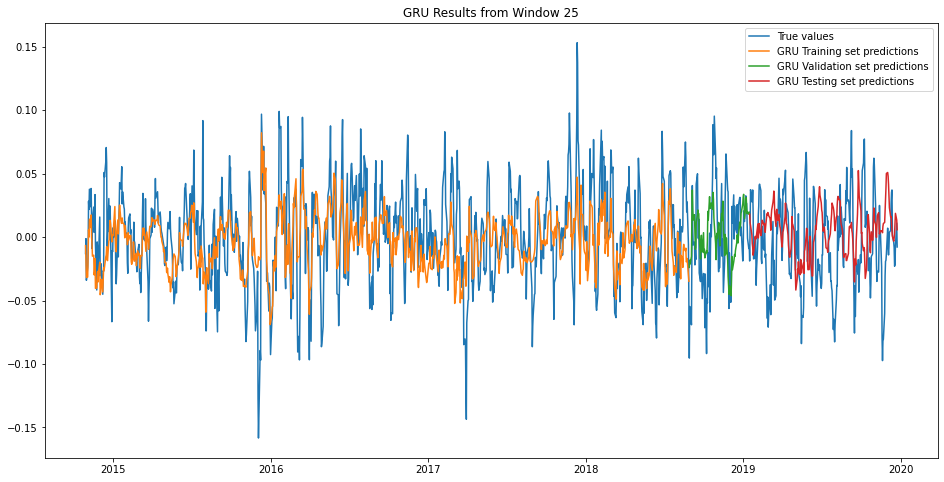

In [10]:
#Declaring model parameters
sequencelength = 174
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
gru_predictions = np.zeros((numPredictions + extra,1)) 
gru_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test GRU 
  gru_model = create_gru()
  gru_history, gru_model = train_gru(gru_model, x_train, y_train, x_val, y_val)
  gru_predictions, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions = makePredictions(gru_model, gru_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions)

  gru_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['GRU Train Predictions'] = gru_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['GRU Val Predictions'] = gru_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['GRU Test Predictions'] = gru_testingPredictions
  
  #Plot GRU Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['GRU Train Predictions'], label = 'GRU Training set predictions')
  plt.plot(valGraph['GRU Val Predictions'], label = 'GRU Validation set predictions')
  plt.plot(testGraph['GRU Test Predictions'], label = 'GRU Testing set predictions')
  plt.title("GRU Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

**Naive and Drift Forecasting Implementation**

In [11]:
def naiveForecasts(dataset, begin, horizon, testingSize):
  '''
  Naive forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    testingSize - Size of the test set
  @returns:
    naive - forecasts for the window
  '''
  naive = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  return naive.reshape((naive.shape[0],1))

def driftForecasts(dataset, begin, horizon, testingSize):
  '''
  Drift forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    horizon - Size of the forecasting Horizon
    testingSize - Size of the test set
  @returns:
    drift - forecasts for the window
  '''
  drift = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  for i in range(2, drift.shape[0] + 1): 
    drift[i - 1] = drift[i - 1] + horizon * ((drift[i - 1] - drift[0]) / (i - 1))
  return drift.reshape((drift.shape[0],1))

#Declaring model parameters
sequencelength = 100
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength 
naive_predictions = np.zeros((numPredictions + extra,1)) 
drift_predictions = np.zeros((numPredictions + extra,1)) 
target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #naive and drift forecasts
  begin = start + trainingSize + validationSize
  naive_predictions[start - sequencelength: start - sequencelength + testingSize, :] = naiveForecasts(dataset, begin, forecastHorizon, testingSize)
  drift_predictions[start - sequencelength: start - sequencelength + testingSize, :] = driftForecasts(dataset, begin, forecastHorizon, testingSize)
  target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Update window parameters
  start += testingSize
  end += testingSize

print("Naive and Drift Forecasts completed")

Naive and Drift Forecasts completed


**Overall Results**

In [12]:
def overall(actual, predictions, model):
  '''
  Calculate the overall performance of the model
  @params:
    actual - True Values
    predictions - Predicted Values
    model - Name of the model used
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print(model + " results on the Testing set")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

#Performance Metrics
overall(lstm_target, lstm_predictions, "LSTM model")
overall(gru_target, gru_predictions, "GRU model")
overall(target, naive_predictions, "Naive model")
overall(target, drift_predictions, "Drift model")

#For Plots
numpreds = 0
if lstm_predictions.shape[0] <= gru_predictions.shape[0]:
  numpreds = lstm_predictions.shape[0]
else:
  numpreds = gru_predictions.shape[0]

testGraph = pd.DataFrame(df[-numpreds:]['Target'])
testGraph['LSTM'] = lstm_predictions[-numpreds:]
testGraph['GRU'] = gru_predictions[-numpreds:]
testGraph['Naive'] = naive_predictions[-numpreds:]
testGraph['Drift'] = drift_predictions[-numpreds:]

LSTM model results on the Testing set
MSE = 0.0016579854224558817
RMSE = 0.0407183671388709
MAE = 0.030584748325273636
R-Squared = -0.19750950645947318

GRU model results on the Testing set
MSE = 0.0015861466971723555
RMSE = 0.03982645725108317
MAE = 0.030444216309165197
R-Squared = -0.14855160127590783

Naive model results on the Testing set
MSE = 0.003095771278972779
RMSE = 0.05563965563312537
MAE = 0.042199995449654526
R-Squared = -1.2326361337218148

Drift model results on the Testing set
MSE = 0.0037443355276342615
RMSE = 0.061190975867641315
MAE = 0.04591427381622684
R-Squared = -1.7003735232495822



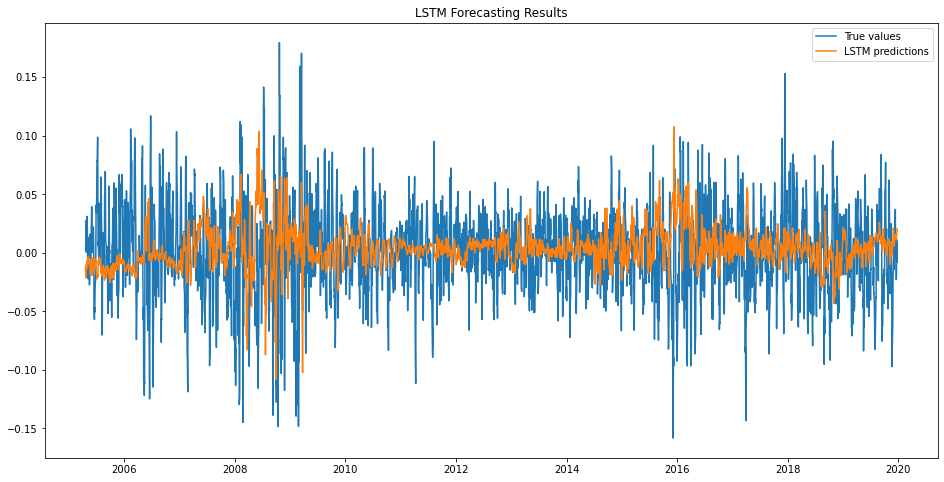

In [13]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['LSTM'], label = 'LSTM predictions')
plt.title("LSTM Forecasting Results")
plt.legend()
plt.show()

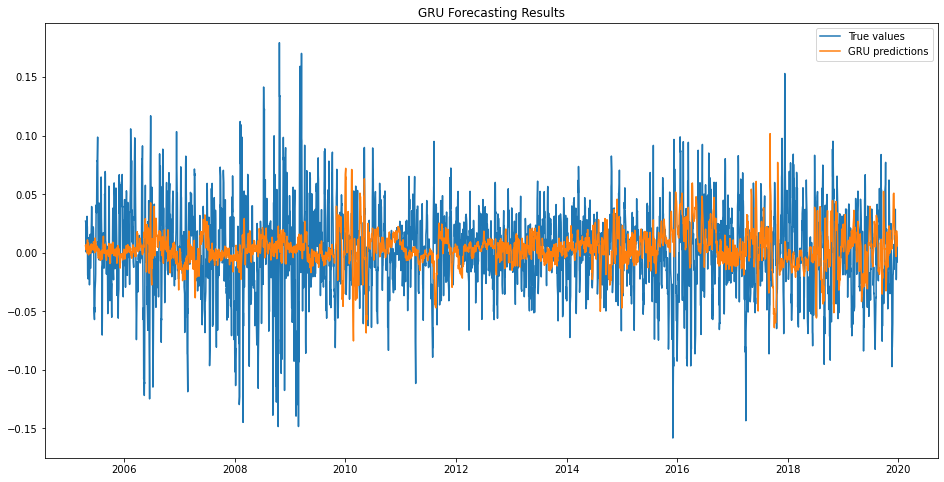

In [14]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['GRU'], label = 'GRU predictions')
plt.title("GRU Forecasting Results")
plt.legend()
plt.show()

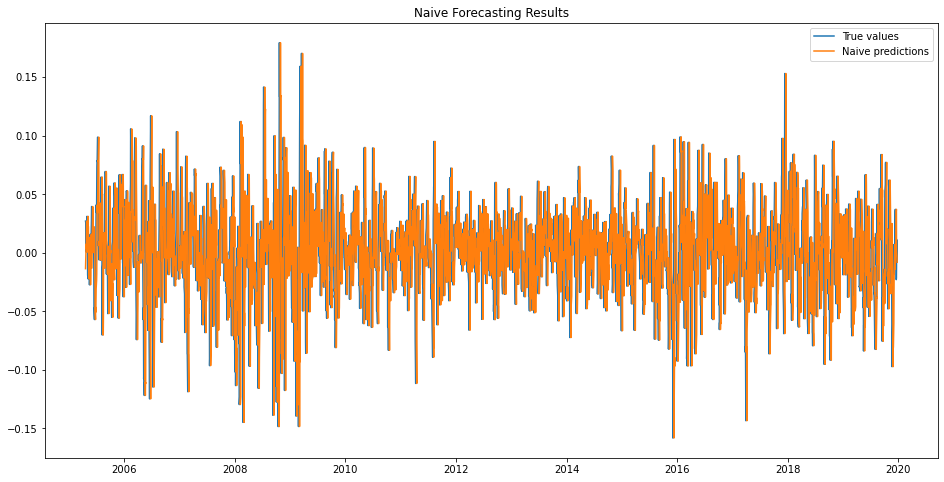

In [15]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Naive'], label = 'Naive predictions')
plt.title("Naive Forecasting Results")
plt.legend()
plt.show()

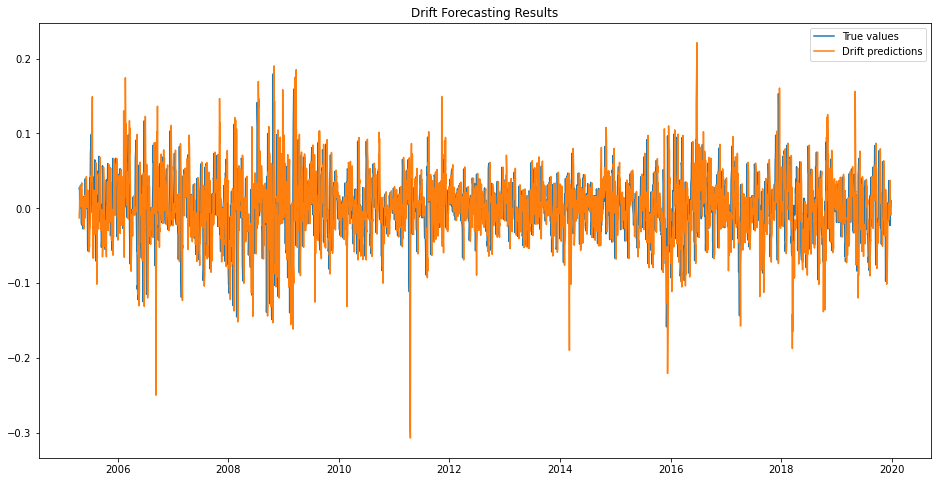

In [16]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Drift'], label = 'Drift predictions')
plt.title("Drift Forecasting Results")
plt.legend()
plt.show()

**Save the predictions to a csv file**

In [17]:
savePredictions = pd.DataFrame(df[-numpreds:]['Target'])

savePredictions['NED LSTM'] = lstm_predictions[-numpreds:]
savePredictions['NED GRU'] = gru_predictions[-numpreds:]
savePredictions['NED Naive'] = naive_predictions[-numpreds:]
savePredictions['NED Drift'] = drift_predictions[-numpreds:]
savePredictions.drop(['Target'], axis=1, inplace=True)

savePredictions.to_csv(r'./NED_Predictions.csv', index=True, header=True)

In [18]:
savePredictions.head()

NED LSTM   NED GRU  NED Naive  NED Drift
Date                                                
2005-04-22 -0.012977  0.006002  -0.013606  -0.012839
2005-04-25 -0.021425  0.002751   0.002599   0.004238
2005-04-26 -0.021176  0.005258   0.007365   0.009243
2005-04-27 -0.011014  0.007089   0.003341   0.004985
2005-04-28 -0.009635  0.003570   0.012138   0.014227